In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [2]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

In [3]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.nanstd(fluxs)


dirpath = os.getcwd().split("code")[0]+"code/obj4"
sys.path.append(dirpath)
from fold import *

def global_fold(t, fluxs, per, t0, T=1000):
    t_fold, val_fold = phase_fold_and_sort_light_curve(t, fluxs, period= per, t0= t0)
    return global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [4]:
from numba import njit, jit
#from numba.typed import List

In [5]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

#@jit(parallel=False, cache=True, fastmath=True)
def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    return lc_wind_nan

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    if num >= estados[0][0]:
        return 0 #si se "sale" por arriba
    elif num <= estados[-1][1]:
        return len(estados)-1 #si se "sale" por abajo
    return 0
    
@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, states):  
    n_sta = len(states)
    transition_m = np.zeros((n_sta,n_sta))
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [6]:
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

In [26]:
%%time
fluxs = our_process[0]
fluxs = prepare_lc(fluxs) #divide by std
lc_tramos =  extract_nans(fluxs) #extract nans
lc_tramos #lista de tramos...

CPU times: user 276 ms, sys: 889 µs, total: 277 ms
Wall time: 275 ms


[array([-2.35041248e-01, -6.72634028e-01, -2.25381310e-01, -5.15211932e-01,
        -6.57111238e-01,  0.00000000e+00,  1.75773845e-01,  2.80903272e-02,
         8.69942808e-01, -4.64923149e-01,  2.89419289e-01, -2.37810716e-01,
         2.13801088e-01,  3.79622406e-01,  4.69755880e-01,  7.78149161e-01,
         8.06878919e-02, -1.87026867e-01,  2.41283372e-01, -4.02722662e-01,
        -1.65855007e-01, -2.30423560e-01,  7.10372532e-01,  1.76539463e-01,
        -3.09386448e-01, -3.36135822e-02, -4.33049929e-01,  5.39667824e-01,
         9.75077892e-02, -4.62457503e-01,  5.39955984e-01,  3.39124094e-01,
        -3.02806249e-02, -2.37169969e-01,  7.57760068e-02, -2.81404169e-01,
        -1.14222877e-01, -5.93060814e-01,  5.98226099e-03, -4.58696002e-01,
         7.33811347e-02,  8.14591333e-02,  2.19896808e-01,  1.55265327e-01,
        -4.88639822e-01, -3.04577881e-01,  1.60366779e-01,  2.03478064e-01,
         5.35508732e-01, -6.92985874e-01,  5.66965866e-02,  7.66829916e-02,
        -3.0

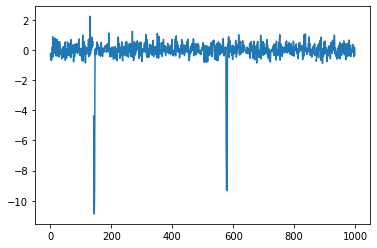

In [27]:
plt.plot(fluxs[:1000])

In [15]:
from scipy import stats

def det_state_norm(n_states, dis):
    w_p = 1./n_states #width of probability
    print("Each bin will have %f perc probability"%(w_p*100))    

    estados_p= []
    estados_num = []
    cum_p = 1
    for n in np.arange(n_states):    
        if n == n_states-1:
            new_p = 0 #no puede ser menor a 0
        else:
            new_p = cum_p - w_p
            
        estados_p.append((cum_p,new_p))
        estados_num.append((dis.ppf(cum_p),dis.ppf(new_p)))
        cum_p = new_p
    return estados_p, estados_num

In [49]:
#definición de estados basados en percentiles de distribucion normal estandar
#???? dependiendo de los percentiles de curva.
norm_stand = stats.norm(loc=0, scale=1)

states_prob, states_values = det_state_norm(32, dis=norm_stand)
states_values

Each bin will have 3.125000 perc probability


[(inf, 1.8627318674216515),
 (1.8627318674216515, 1.5341205443525463),
 (1.5341205443525463, 1.318010897303537),
 (1.318010897303537, 1.1503493803760079),
 (1.1503493803760079, 1.009990169249582),
 (1.009990169249582, 0.887146559018876),
 (0.887146559018876, 0.7764217611479277),
 (0.7764217611479277, 0.6744897501960817),
 (0.6744897501960817, 0.579132162255556),
 (0.579132162255556, 0.4887764111146695),
 (0.4887764111146695, 0.40225006532172536),
 (0.40225006532172536, 0.31863936396437514),
 (0.31863936396437514, 0.23720210932878769),
 (0.23720210932878769, 0.1573106846101707),
 (0.1573106846101707, 0.0784124127331122),
 (0.0784124127331122, 0.0),
 (0.0, -0.0784124127331122),
 (-0.0784124127331122, -0.1573106846101707),
 (-0.1573106846101707, -0.23720210932878769),
 (-0.23720210932878769, -0.31863936396437514),
 (-0.31863936396437514, -0.40225006532172536),
 (-0.40225006532172536, -0.4887764111146695),
 (-0.4887764111146695, -0.579132162255556),
 (-0.579132162255556, -0.674489750196081

In [115]:
skew_gumb = stats.gumbel_l(loc=0, scale=1) #distribucion con sesgo negativos

states_prob, states_values = det_state_norm(32, dis=skew_gumb) 
states_values

Each bin will have 3.125000 perc probability


[(-inf, -3.4499035524498507),
 (-3.4499035524498507, -2.740493006510356),
 (-2.740493006510356, -2.3183073137881562),
 (-2.3183073137881562, -2.013418678039948),
 (-2.013418678039948, -1.7725509195645972),
 (-1.7725509195645972, -1.5719525272733839),
 (-1.5719525272733839, -1.3989335889752197),
 (-1.3989335889752197, -1.2458993237072382),
 (-1.2458993237072382, -1.1079305081279383),
 (-1.1079305081279383, -0.9816470554772615),
 (-0.9816470554772615, -0.8646155308660016),
 (-0.8646155308660016, -0.7550148625084083),
 (-0.7550148625084083, -0.6514354885619831),
 (-0.6514354885619831, -0.5527521431472929),
 (-0.5527521431472929, -0.4580393930188333),
 (-0.4580393930188333, -0.36651292058166435),
 (-0.36651292058166435, -0.2774866208873519),
 (-0.2774866208873519, -0.19033932554921443),
 (-0.19033932554921443, -0.1044869580557397),
 (-0.1044869580557397, -0.0193568885804821),
 (-0.0193568885804821, 0.06563850655799441),
 (0.06563850655799441, 0.1511325382214278),
 (0.1511325382214278, 0.23

Mean data,  -0.0734976179540745
std data,  1.0
skeww data,  -7.969773150674416
[-] Mean data,  -0.48725108516466026
[-] std data,  1.2440909446527153
[-] skeww data,  -7.284461492741001


/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


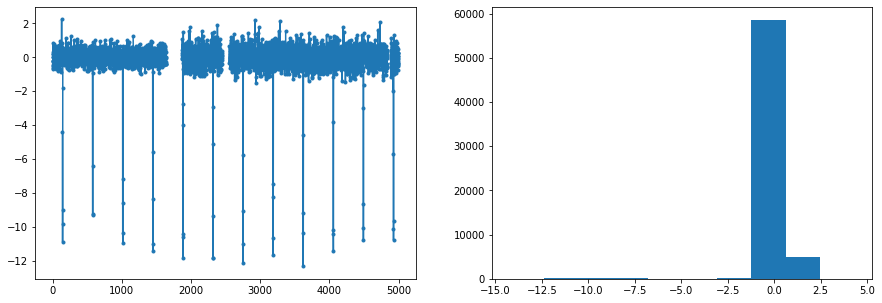

Mean data,  0.023070235168148885
std data,  1.0000000000000002
skeww data,  0.20953997173654793
[-] Mean data,  -0.7368559455983574
[-] std data,  0.6037925803831318
[-] skeww data,  -1.1261322714770396


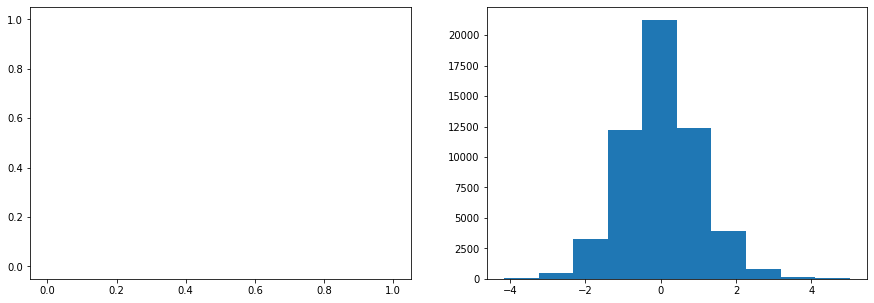

Mean data,  -0.03488516231256785
std data,  0.9999999999999999
skeww data,  -7.6943684200890665
[-] Mean data,  -0.5649186685743848
[-] std data,  1.0417262861635215
[-] skeww data,  -12.301773969272388


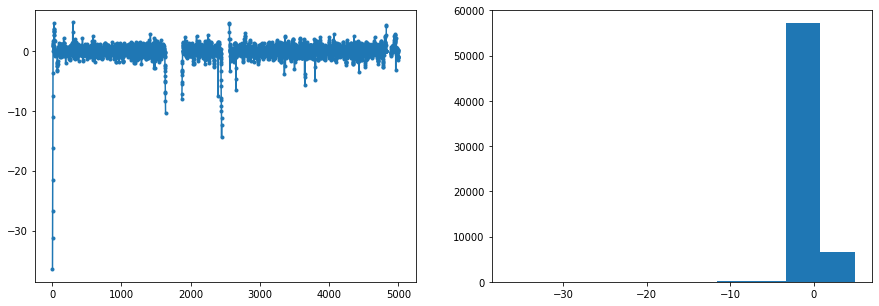

Mean data,  -0.1722315642166646
std data,  0.9999999999999999
skeww data,  -7.05610637190483
[-] Mean data,  -0.38022012577022146
[-] std data,  1.3581724577836467
[-] skeww data,  -4.997172693332363


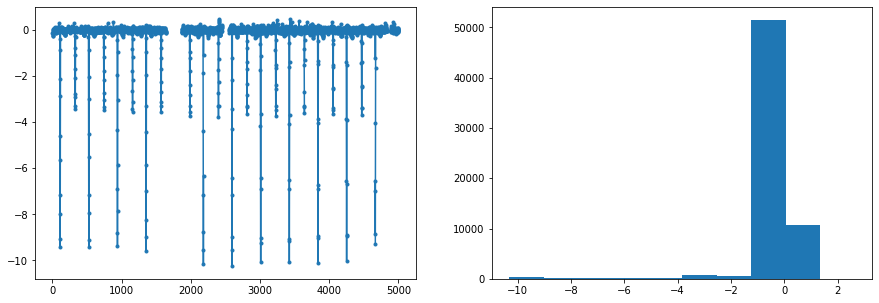

Mean data,  -0.006655754918061232
std data,  0.9999999999999999
skeww data,  -1.4154614109022705
[-] Mean data,  -0.7066591128440773
[-] std data,  0.7757624227499756
[-] skeww data,  -6.002366896642053


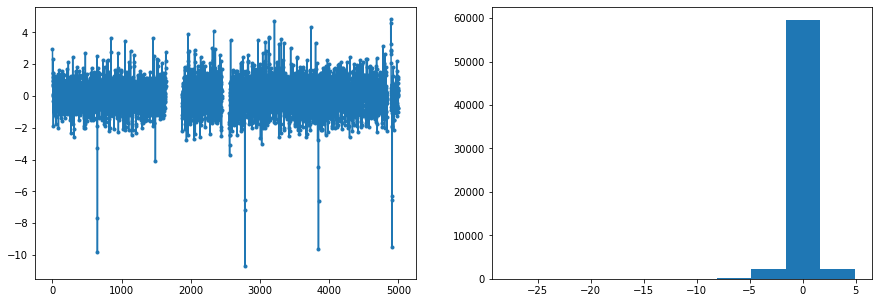

Mean data,  -0.06248495154197505
std data,  1.0
skeww data,  -3.1575406112757975
[-] Mean data,  -0.6409375521239559
[-] std data,  1.032853349316427
[-] skeww data,  -4.606456287191914


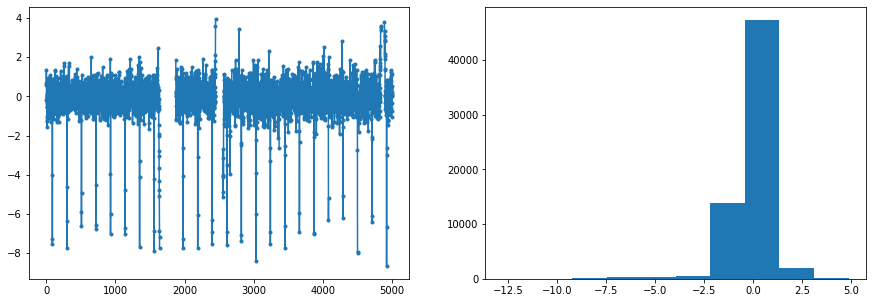

Mean data,  0.006502331583971624
std data,  1.0
skeww data,  -0.039094181943746004
[-] Mean data,  -0.7587730511089751
[-] std data,  0.6273345839513665
[-] skeww data,  -1.7614361908610083


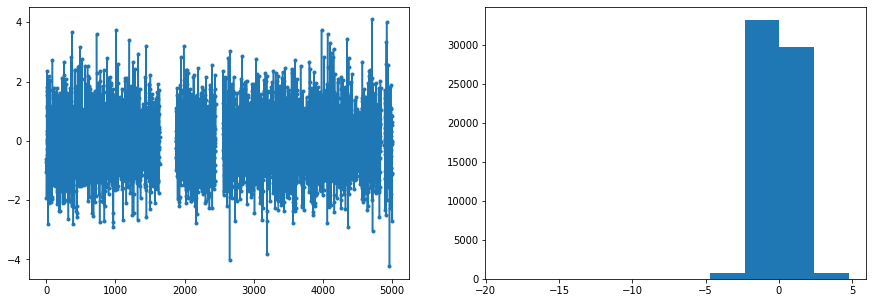

Mean data,  0.016949202632504067
std data,  0.9999999999999998
skeww data,  0.1720244003276335
[-] Mean data,  -0.7450933193794226
[-] std data,  0.6085034470149793
[-] skeww data,  -1.0897269518666135


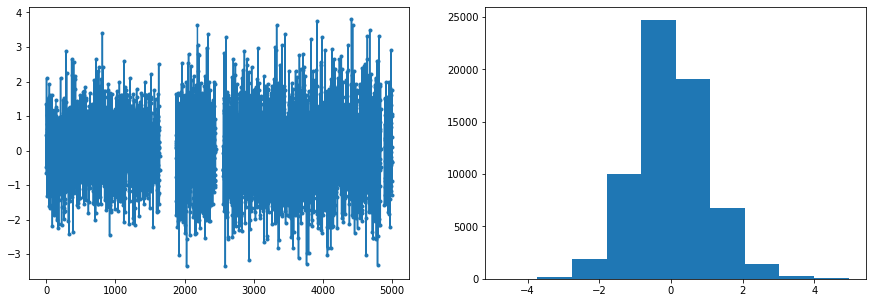

Mean data,  0.018193532246251767
std data,  0.9999999999999999
skeww data,  0.17106227569173413
[-] Mean data,  -0.7439555520449039
[-] std data,  0.6093789677781766
[-] skeww data,  -1.069436967297495


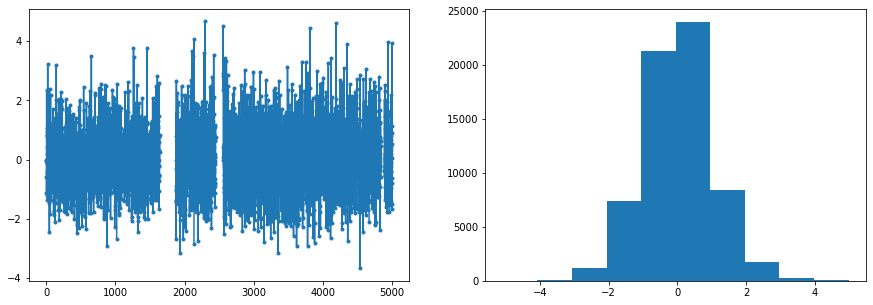

Mean data,  -0.027181535596990217
std data,  1.0
skeww data,  -26.617818457162983
[-] Mean data,  -0.26902415595204004
[-] std data,  1.3513272485127439
[-] skeww data,  -20.82900010026537


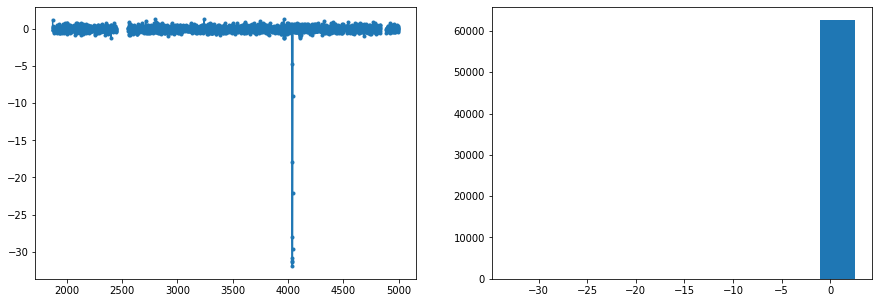

Mean data,  0.02477880800960691
std data,  0.9999999999999999
skeww data,  0.21443412640464504
[-] Mean data,  -0.7331991638338862
[-] std data,  0.6031929715519624
[-] skeww data,  -1.1956306810893902


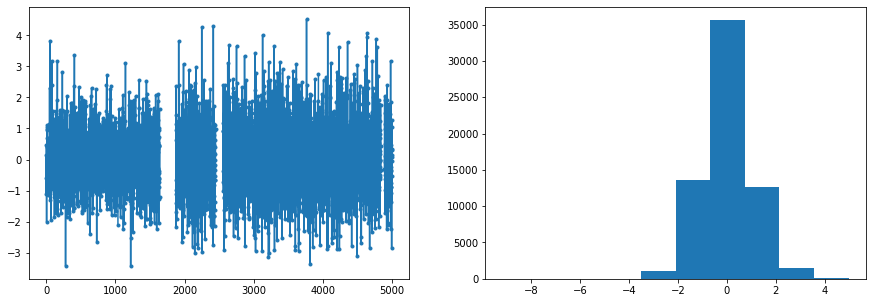

Mean data,  0.02331908552158229
std data,  1.0
skeww data,  0.21601260676962653
[-] Mean data,  -0.7336564869554947
[-] std data,  0.6043455873616866
[-] skeww data,  -1.198290699852417


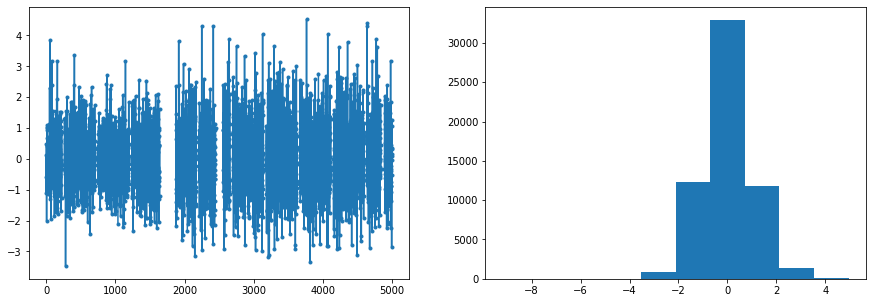

Mean data,  0.021753677638480847
std data,  1.0
skeww data,  0.1527252688803296
[-] Mean data,  -0.7345614945793167
[-] std data,  0.6137168028652232
[-] skeww data,  -1.3332809157752716


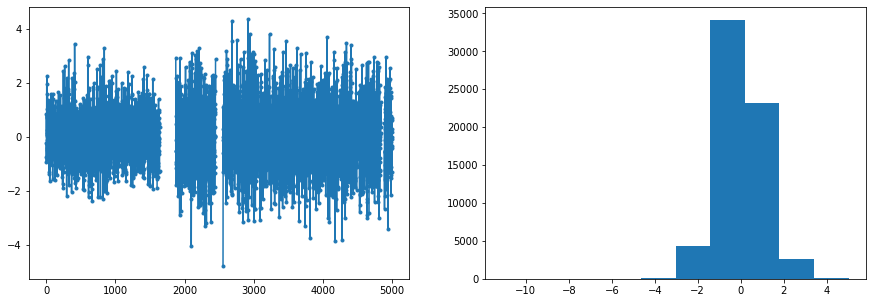

Mean data,  -0.042735335776778405
std data,  1.0
skeww data,  -3.8955864178939428
[-] Mean data,  -0.2823250471647816
[-] std data,  1.096976344492322
[-] skeww data,  -6.440647675255049


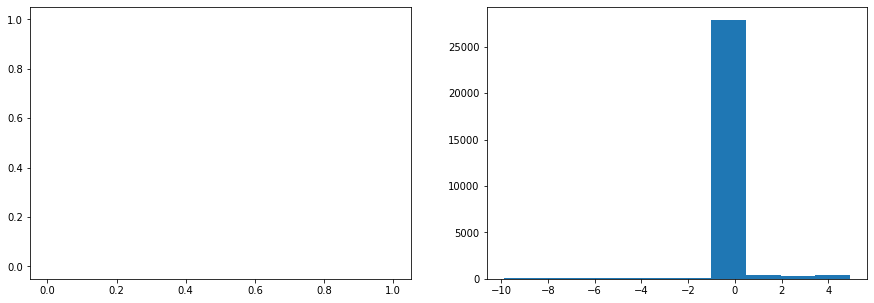

Mean data,  -0.0043446026075020195
std data,  1.0
skeww data,  0.0349253863567142
[-] Mean data,  -0.7413138561898105
[-] std data,  0.6564560144087308
[-] skeww data,  -1.1437975936695521


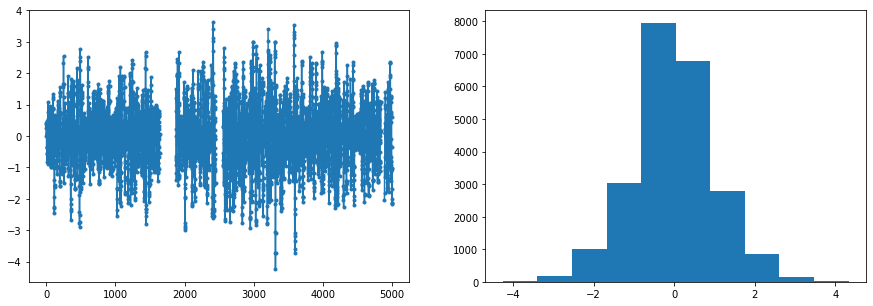

Mean data,  -0.12069617131554693
std data,  1.0
skeww data,  -6.721396279624247
[-] Mean data,  -0.4144020968782195
[-] std data,  1.300309141386107
[-] skeww data,  -5.4319565081984775


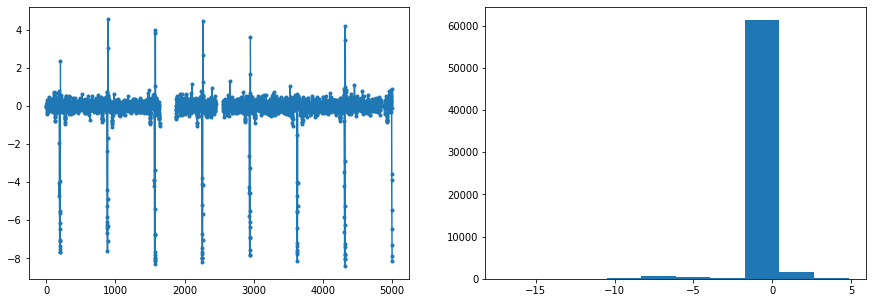

Mean data,  0.017901681785803057
std data,  1.0
skeww data,  0.16038937932351854
[-] Mean data,  -0.743923721456066
[-] std data,  0.6072406549338648
[-] skeww data,  -1.0120783079165452


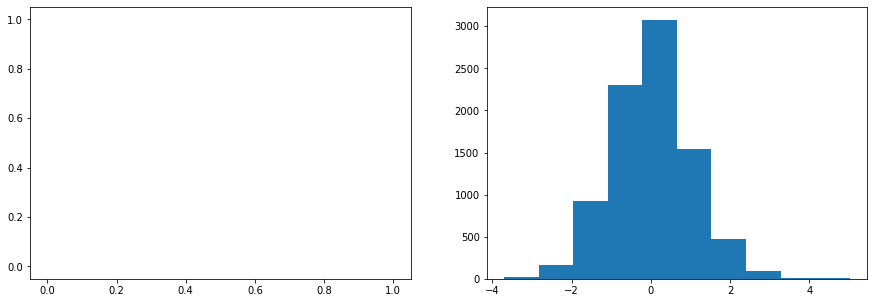

Mean data,  -0.20203603360130862
std data,  1.0
skeww data,  -4.475949104905542
[-] Mean data,  -0.5615894834851322
[-] std data,  1.301420435392244
[-] skeww data,  -3.237377327829415


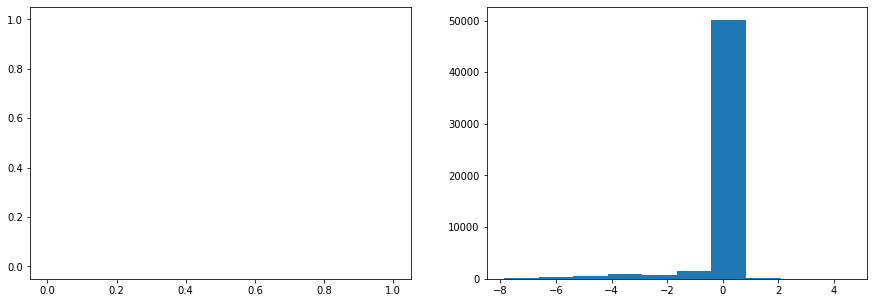

Mean data,  0.006113549623970852
std data,  1.0000000000000002
skeww data,  0.030661479077298895
[-] Mean data,  -0.7524269256007293
[-] std data,  0.6325081964537843
[-] skeww data,  -1.2868542642342455


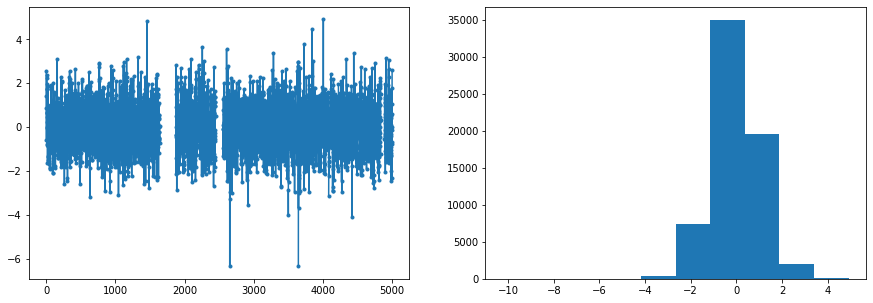

Mean data,  0.022141745215525227
std data,  1.0
skeww data,  0.19535576385854356
[-] Mean data,  -0.7380470423811202
[-] std data,  0.6052587996252546
[-] skeww data,  -1.192885389603506


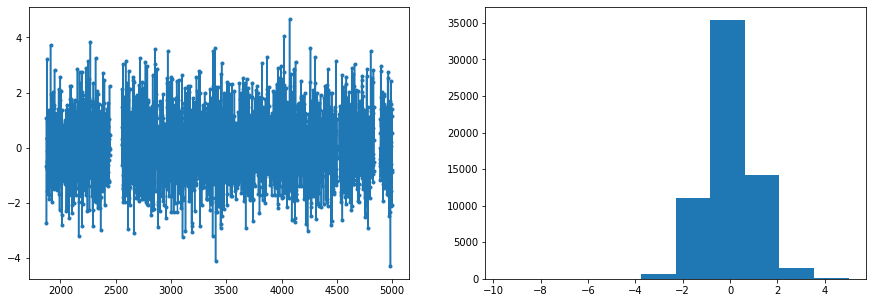

In [134]:
for i in range(20):
    fluxs = our_process[i]
    fluxs = prepare_lc(fluxs) #divide by std
    print("Mean data, ",np.nanmean(fluxs))
    print("std data, ",np.nanstd(fluxs))
    print("skeww data, ",stats.skew(fluxs, nan_policy='omit'))
    
    mask_v = fluxs <= 0
    print("[-] Mean data, ",np.nanmean(fluxs[mask_v]))
    print("[-] std data, ",np.nanstd(fluxs[mask_v]))
    print("[-] skeww data, ",stats.skew(fluxs[mask_v], nan_policy='omit'))

    f, axx = plt.subplots(1, 2,figsize= (15,5))

    axx[0].plot(fluxs[:5000],'.-')
    
    #mask_v = fluxs < 0
    #print("Mean negatives ",np.mean(fluxs[mask_v]))
    axx[1].hist(fluxs[:])
    plt.show()

In [109]:
skew = -7
states_prob, states_values = det_state_norm(32, dis=stats.skewnorm(a=skew ,loc=0, scale=1))
states_values

Each bin will have 3.125000 perc probability


[(-inf, -2.1538746940614195),
 (-2.1538746940614195, -1.8627318674216513),
 (-1.8627318674216513, -1.675939722773444),
 (-1.675939722773444, -1.5341205443525463),
 (-1.5341205443525463, -1.4177971379962673),
 (-1.4177971379962673, -1.3180108973035365),
 (-1.3180108973035365, -1.2298587592165893),
 (-1.2298587592165893, -1.1503493803760083),
 (-1.1503493803760083, -1.0775155670402805),
 (-1.0775155670402805, -1.0099901692495674),
 (-1.0099901692495674, -0.9467817563006997),
 (-0.9467817563006997, -0.8871465590131755),
 (-0.8871465590131755, -0.8305108781355218),
 (-0.8305108781355218, -0.7764217604825011),
 (-0.7764217604825011, -0.72451437839982),
 (-0.72451437839982, -0.6744897180112062),
 (-0.6744897180112062, -0.6260988406060326),
 (-0.6260988406060326, -0.5791313742313511),
 (-0.5791313742313511, -0.5334065490855971),
 (-0.5334065490855971, -0.48876522246580617),
 (-0.48876522246580617, -0.4450610552619424),
 (-0.4450610552619424, -0.40214847092346717),
 (-0.40214847092346717, -0.3

/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


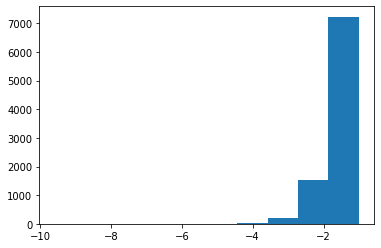

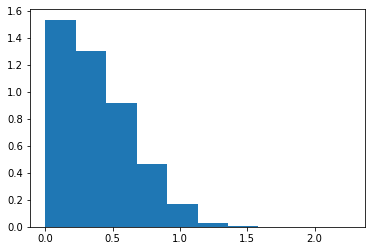

Mean log 0.3810275431873475


In [182]:
mask_v = (fluxs <= -1) & (~np.isnan(fluxs))
plt.hist(fluxs[mask_v])
plt.show()
plt.hist(np.log(-fluxs[mask_v]), density=True)
#x = np.linspace(exponential.ppf(0.01),  exponential.ppf(0.99), 100)
#plt.plot(x,exponential.pdf(x))
plt.show()
print("Mean log", np.mean(np.log(-fluxs[mask_v])))

In [170]:
exponential = stats.expon(loc=0, scale=0.38) #distribucion con sesgo

states_prob, states_values = det_state_norm(32, dis=exponential) 
states_values

Each bin will have 3.125000 perc probability


[(0.0, 0.012064505359540513),
 (0.012064505359540513, 0.024524638032277047),
 (0.024524638032277047, 0.03740722766903596),
 (0.03740722766903596, 0.0507419291973186),
 (0.0507419291973186, 0.06456163398225104),
 (0.06456163398225104, 0.07890295861573292),
 (0.07890295861573292, 0.0938068296139798),
 (0.0938068296139798, 0.10931918753167674),
 (0.10931918753167674, 0.1254918410108192),
 (0.1254918410108192, 0.14238351078773606),
 (0.14238351078773606, 0.16006111672899534),
 (0.16006111672899534, 0.17860137911337953),
 (0.17860137911337953, 0.1980928309806487),
 (0.1980928309806487, 0.21863837506335349),
 (0.21863837506335349, 0.240358572322534),
 (0.240358572322534, 0.2633959286127792),
 (0.2633959286127792, 0.2879205666450563),
 (0.2879205666450563, 0.3141378578100978),
 (0.3141378578100978, 0.34229888722851215),
 (0.34229888722851215, 0.37271511614445596),
 (0.37271511614445596, 0.4057794394005153),
 (0.4057794394005153, 0.44199730772615875),
 (0.44199730772615875, 0.48203430367613276

### Comportamiento Falsos postiviso

In [45]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

(3976, 71427)

recuperando curva 1


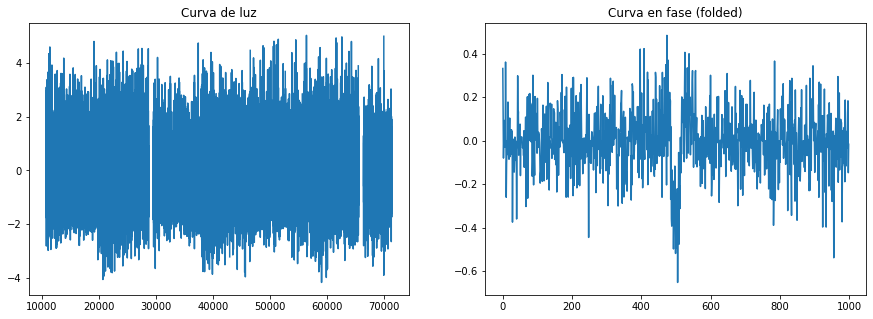

Each bin will have 3.125000 perc probability


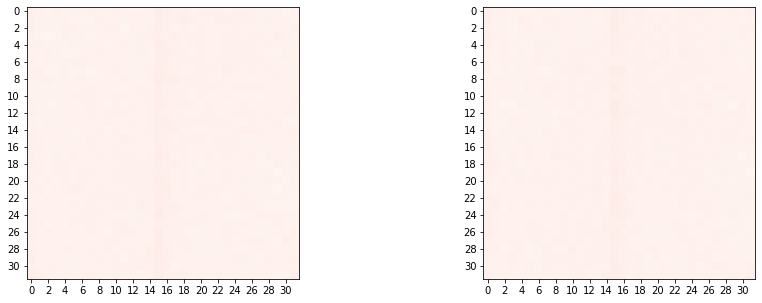

recuperando curva 2


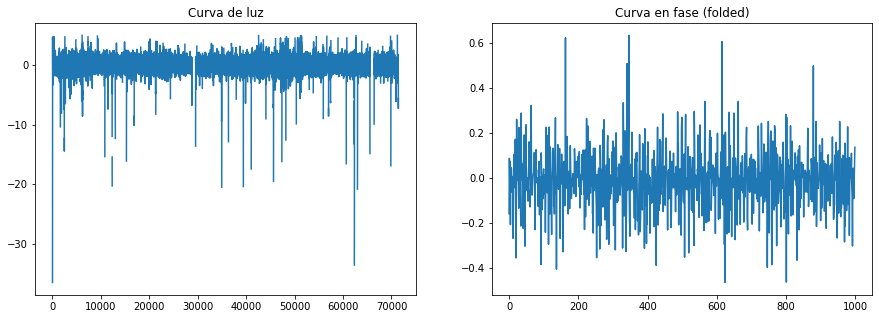

Each bin will have 3.125000 perc probability


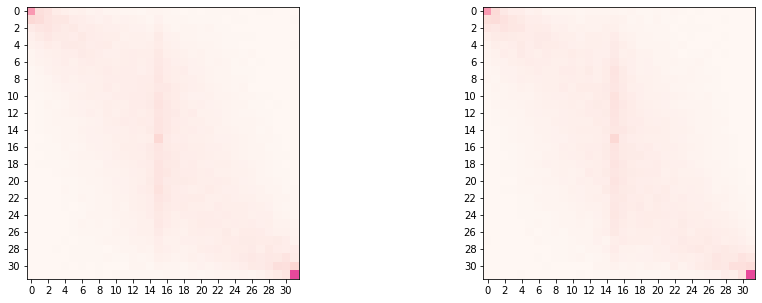

recuperando curva 3


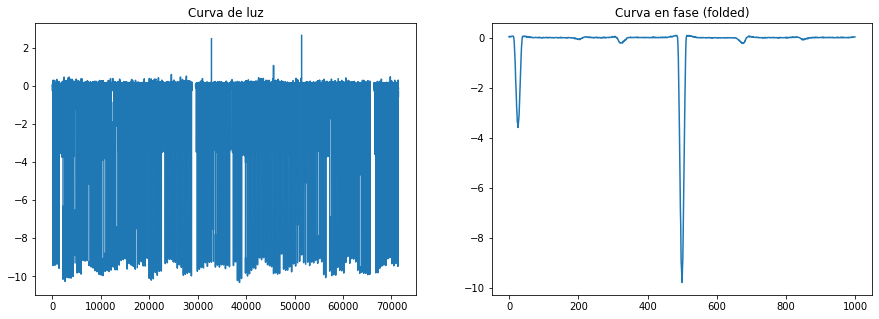

Each bin will have 3.125000 perc probability


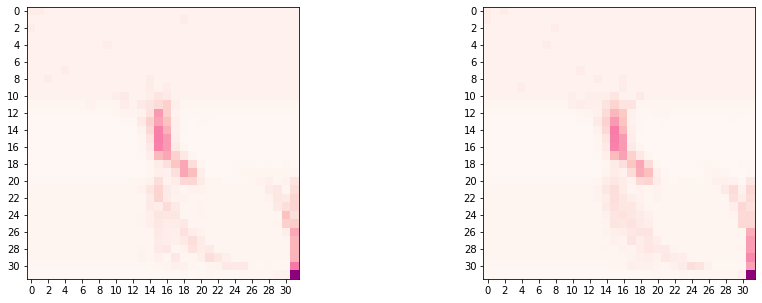

recuperando curva 4


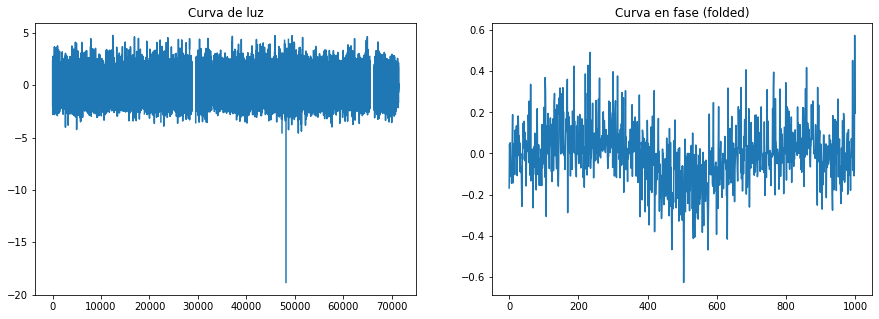

Each bin will have 3.125000 perc probability


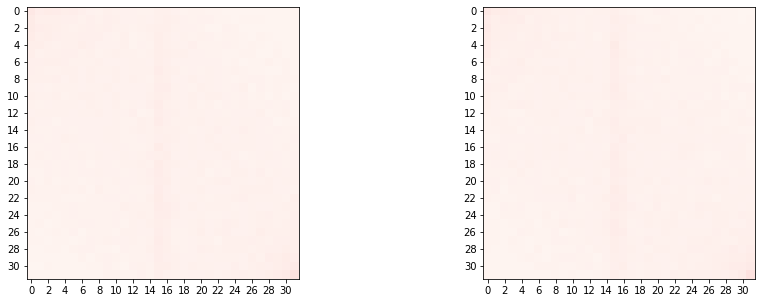

recuperando curva 5


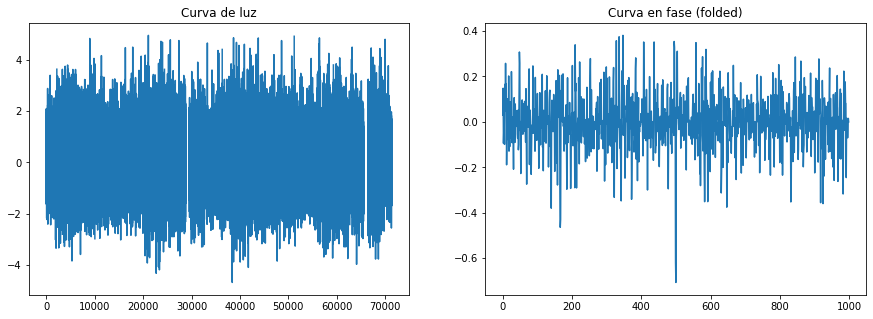

Each bin will have 3.125000 perc probability


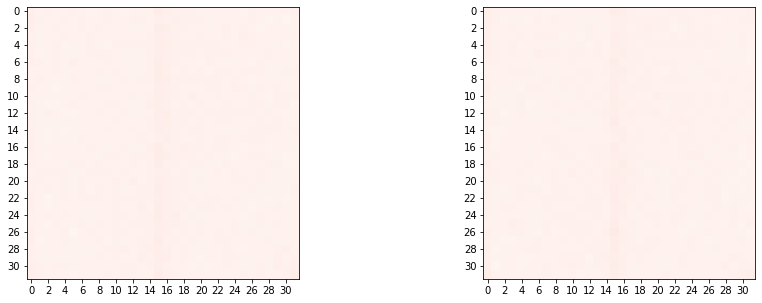

recuperando curva 6


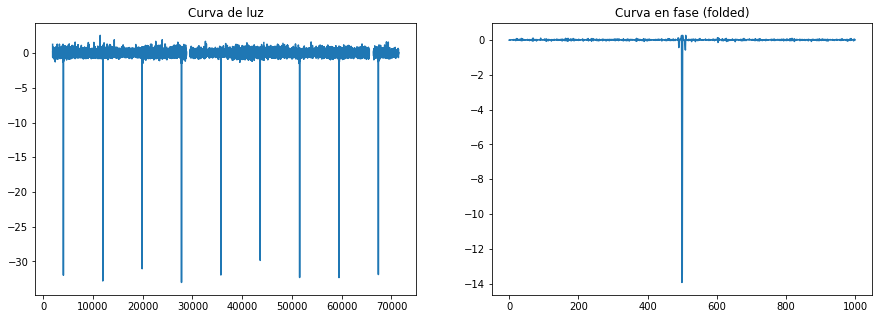

Each bin will have 3.125000 perc probability


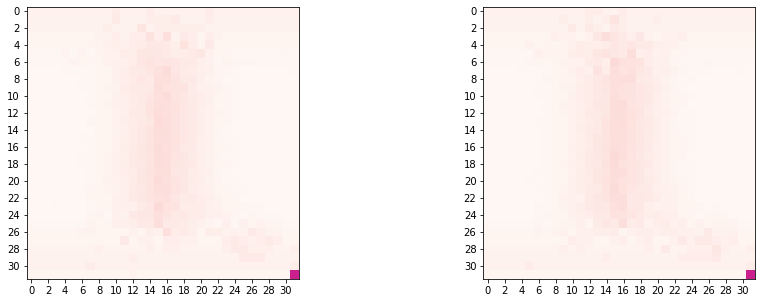

recuperando curva 7


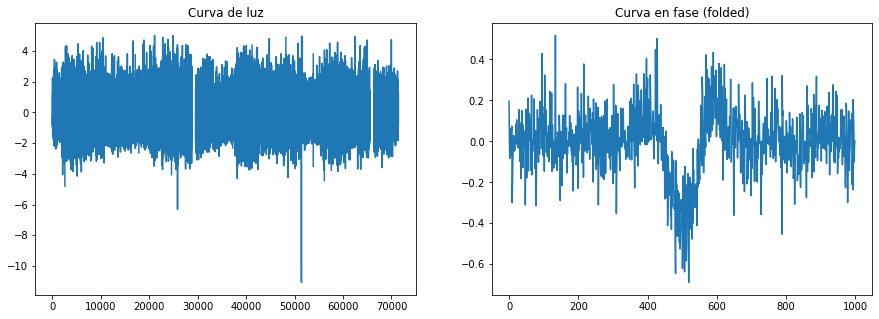

Each bin will have 3.125000 perc probability


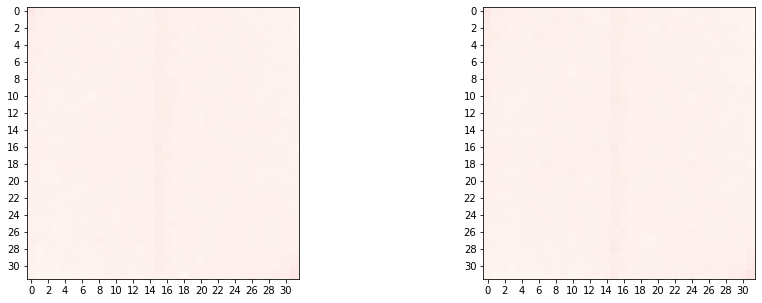

recuperando curva 8


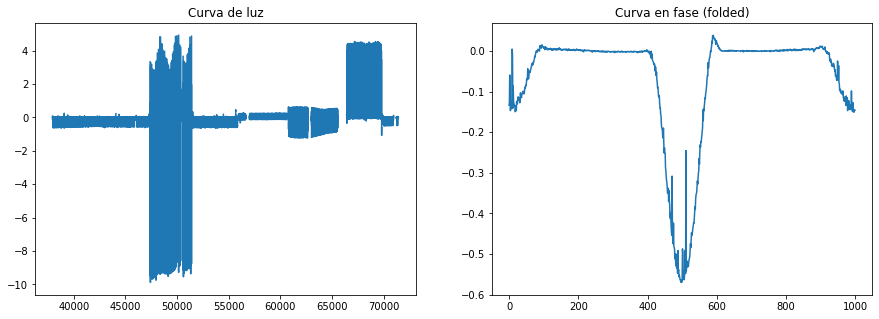

Each bin will have 3.125000 perc probability


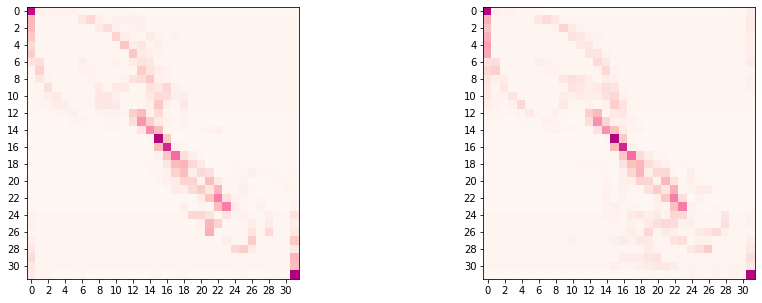

recuperando curva 9


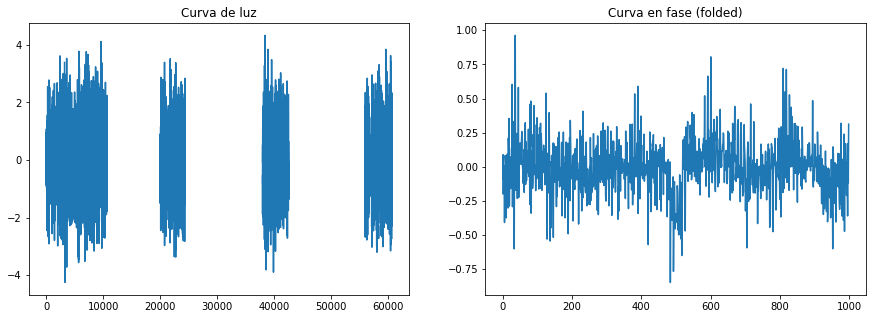

Each bin will have 3.125000 perc probability


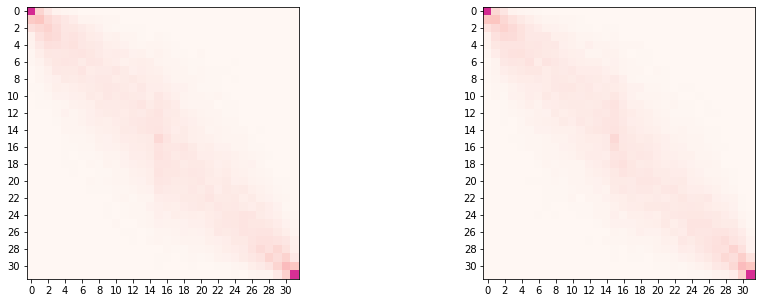

recuperando curva 10


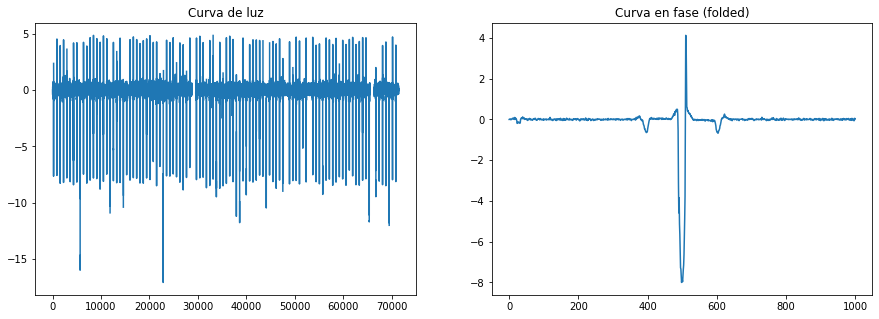

Each bin will have 3.125000 perc probability


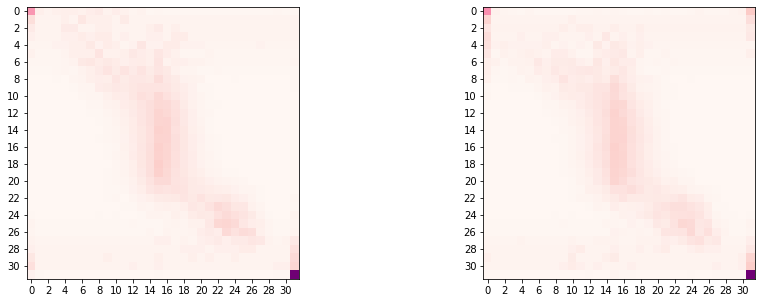

recuperando curva 11


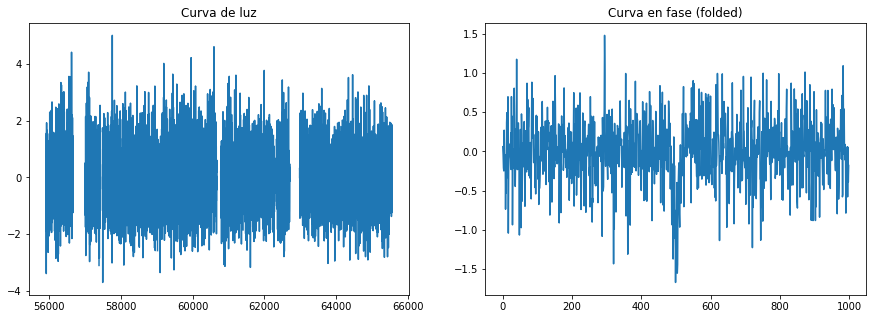

Each bin will have 3.125000 perc probability


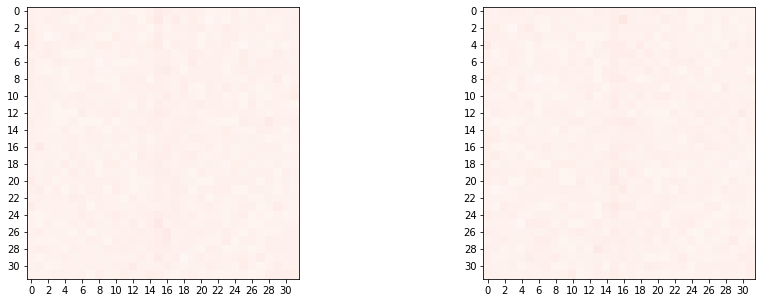

recuperando curva 12


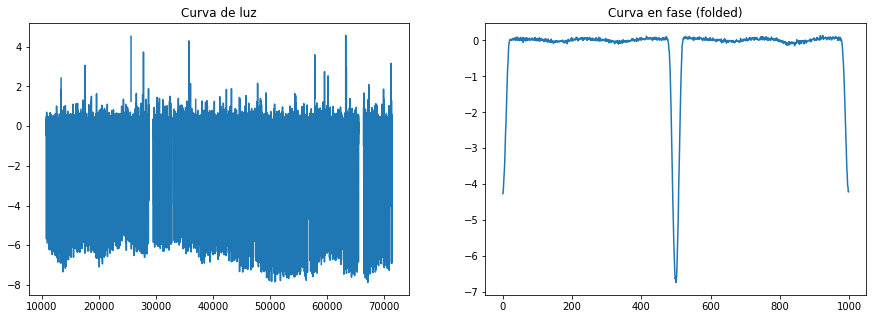

Each bin will have 3.125000 perc probability


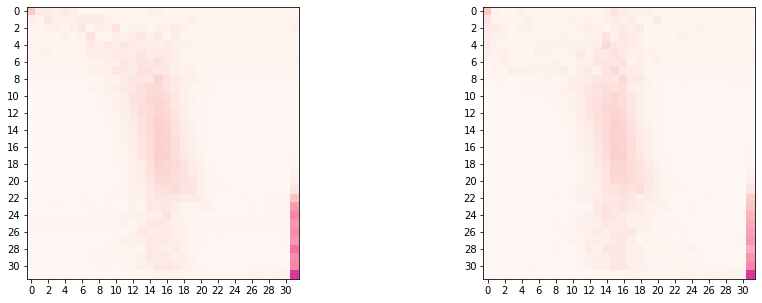

recuperando curva 13


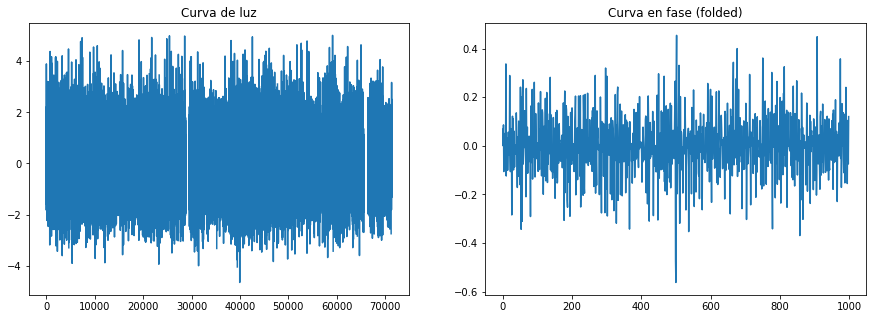

Each bin will have 3.125000 perc probability


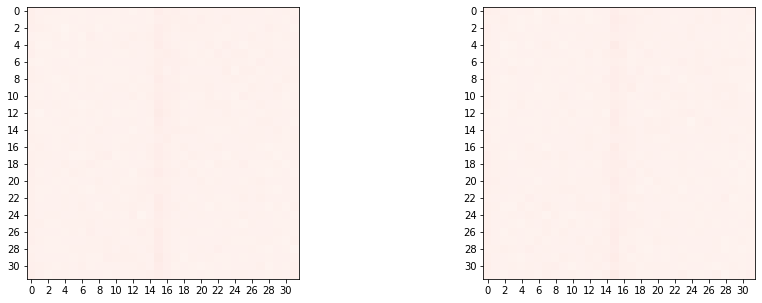

recuperando curva 14


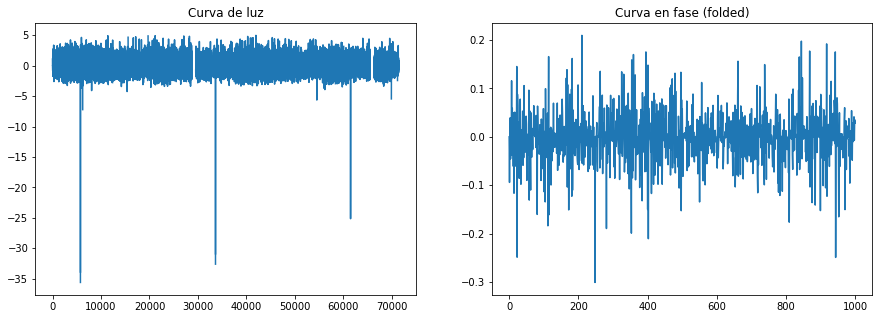

Each bin will have 3.125000 perc probability


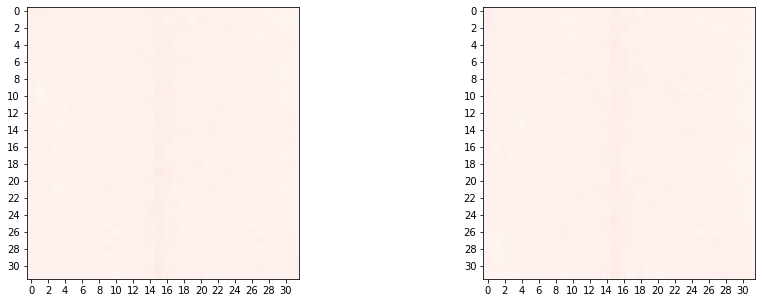

recuperando curva 15


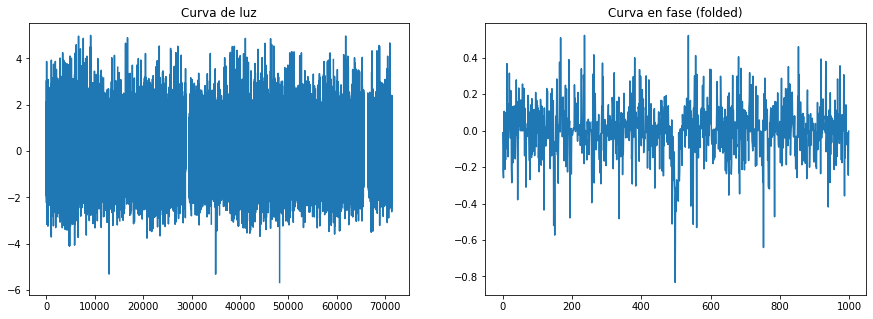

Each bin will have 3.125000 perc probability


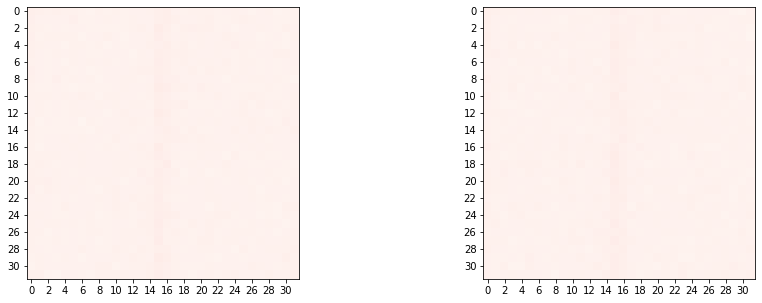

recuperando curva 16


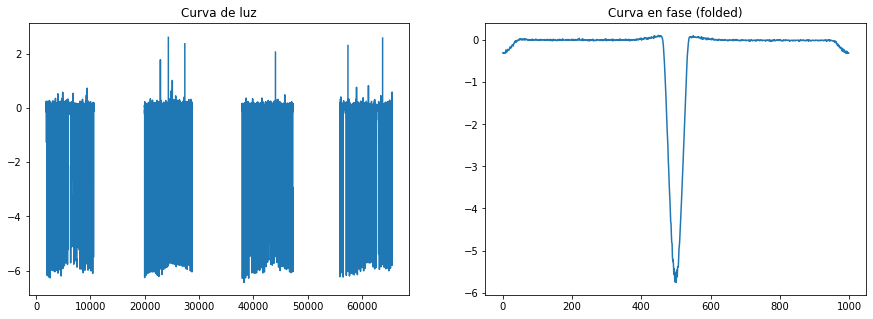

Each bin will have 3.125000 perc probability


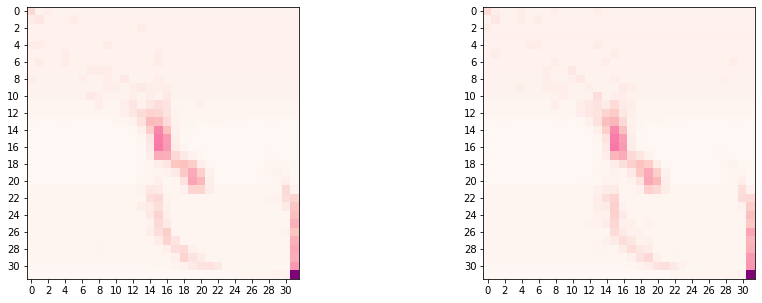

recuperando curva 17


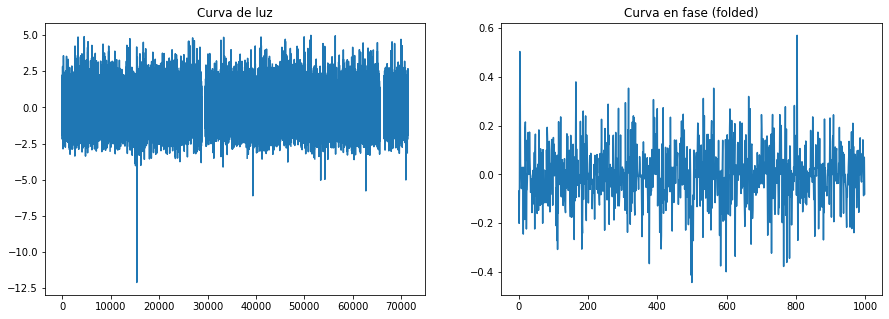

Each bin will have 3.125000 perc probability


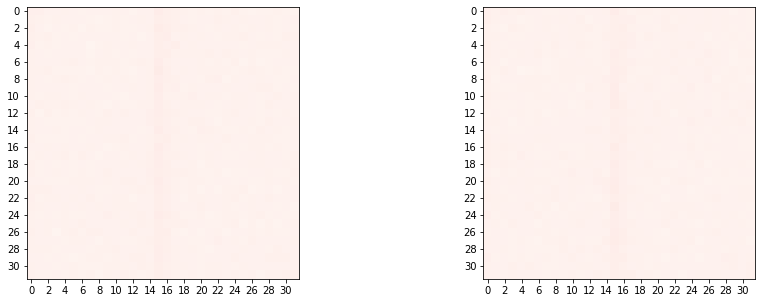

recuperando curva 18


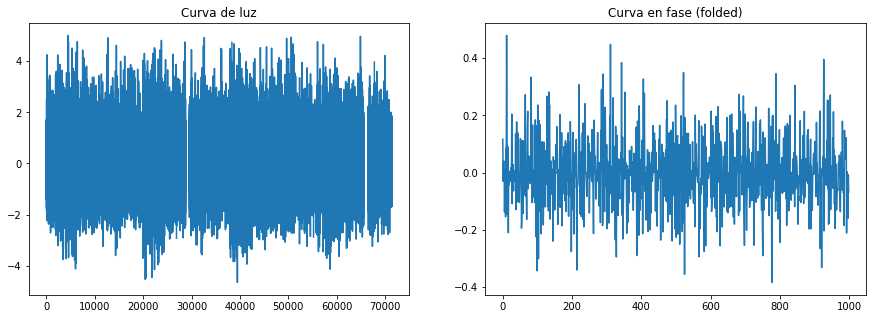

Each bin will have 3.125000 perc probability


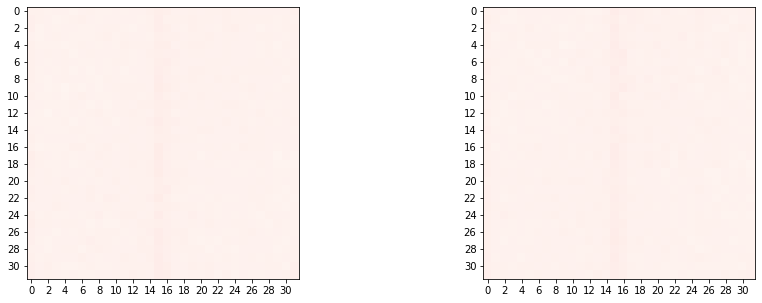

recuperando curva 19


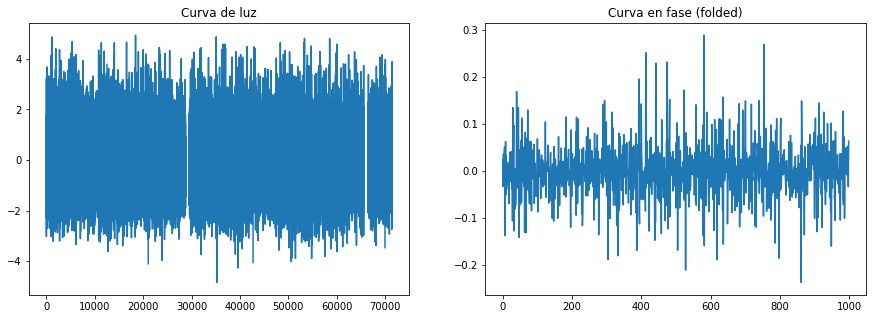

Each bin will have 3.125000 perc probability


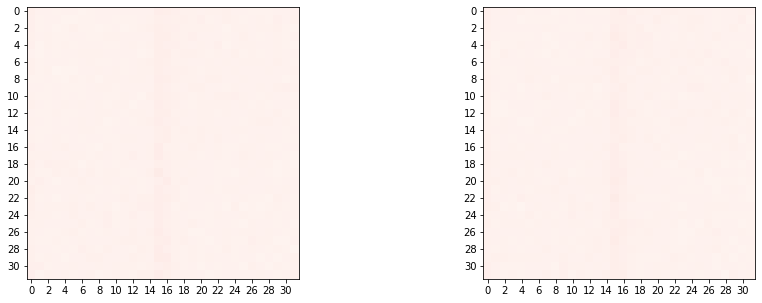

recuperando curva 20


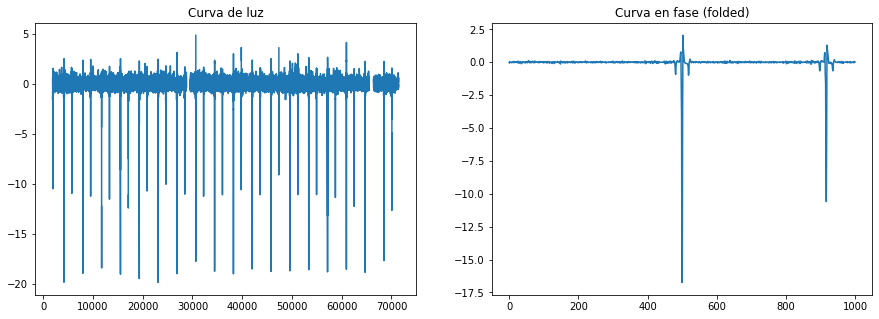

Each bin will have 3.125000 perc probability


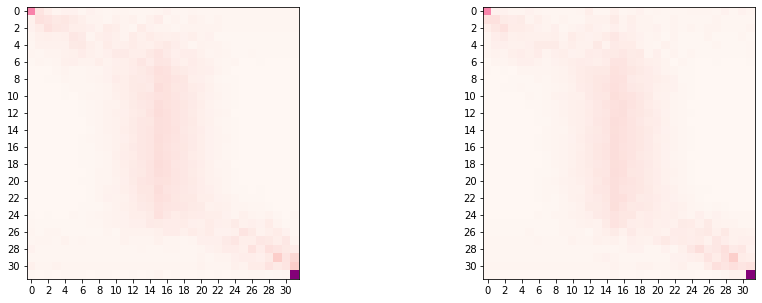

CPU times: user 52.5 s, sys: 10.4 s, total: 1min 2s
Wall time: 1min 1s


In [61]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    dis_ = stats.norm(loc=0, scale=1)
    states_prob, states_values = det_state_norm(32, dis=dis_)
    
    transition_m = manual_HMM(lc_tramos, states_values) 

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, states_values) 
    
    axx[1].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

recuperando curva 1


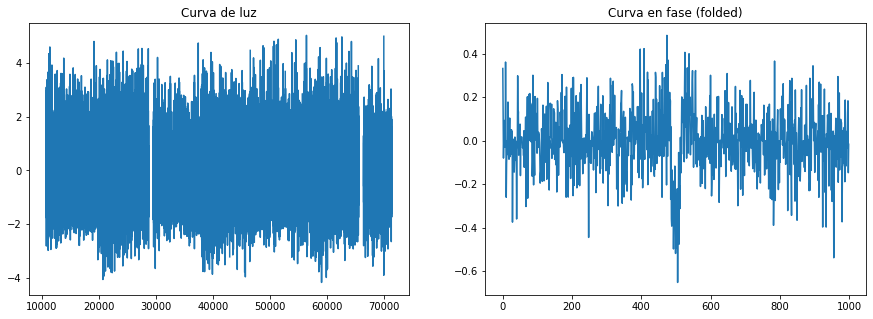

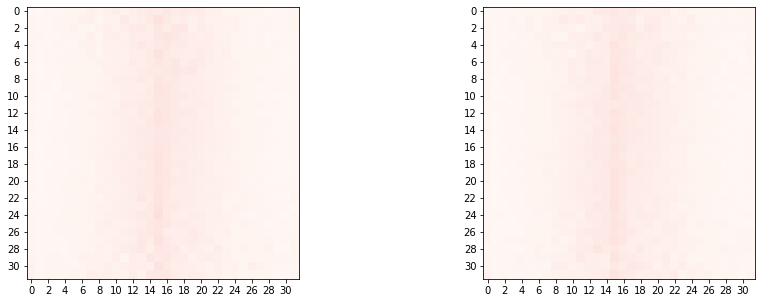

recuperando curva 2


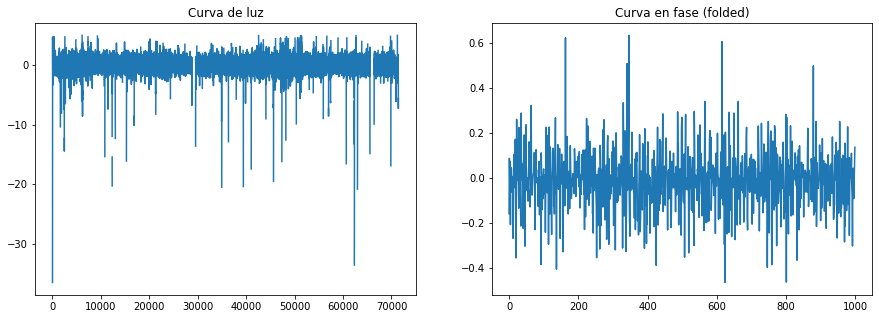

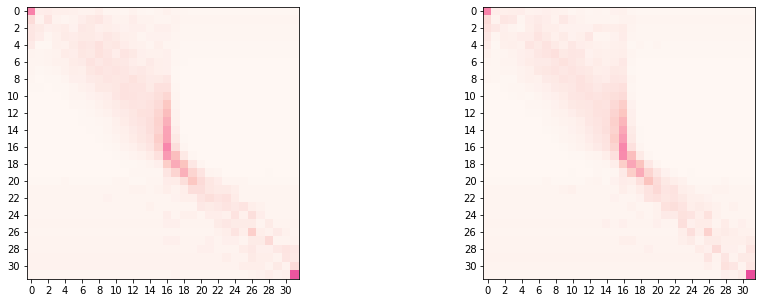

recuperando curva 3


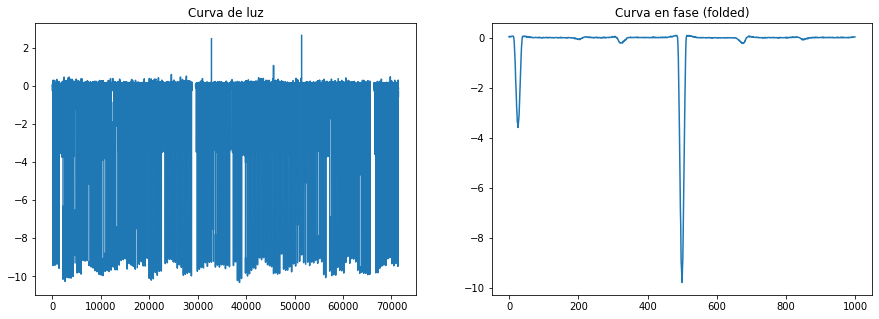

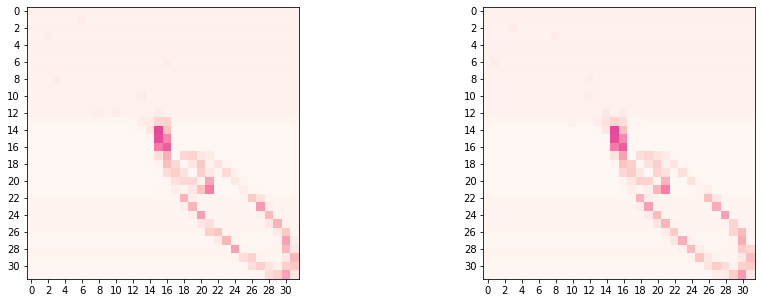

recuperando curva 4


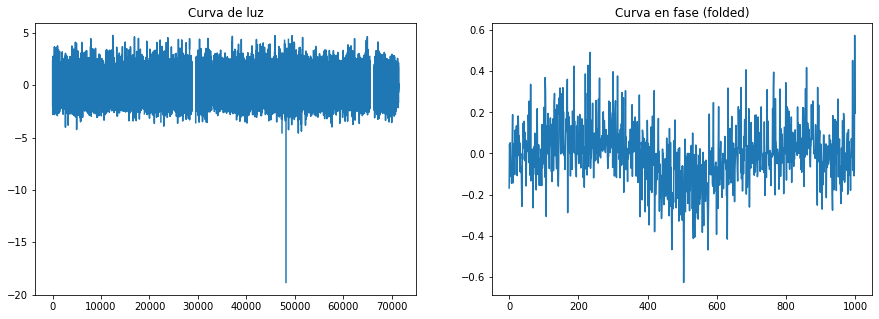

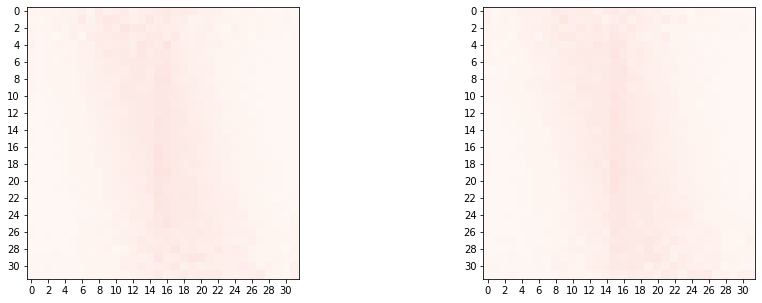

recuperando curva 5


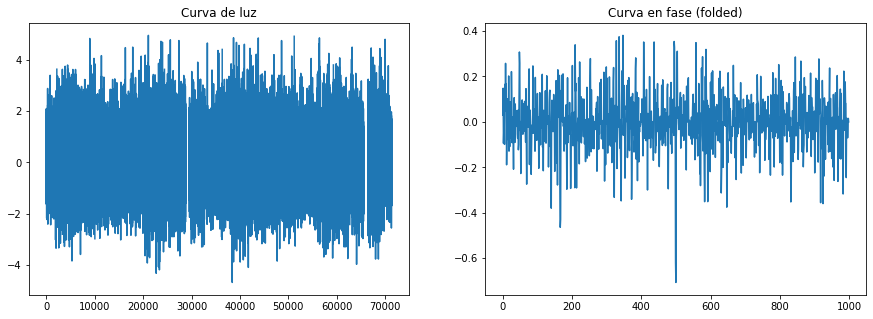

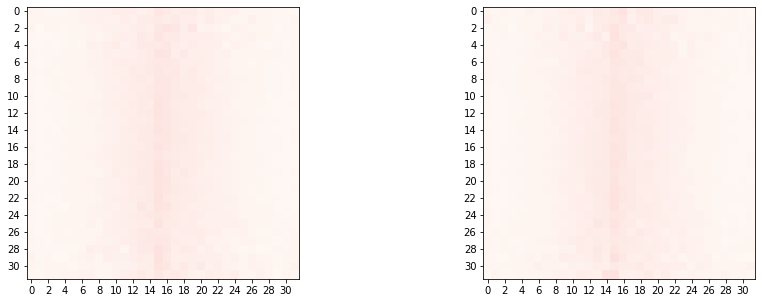

recuperando curva 6


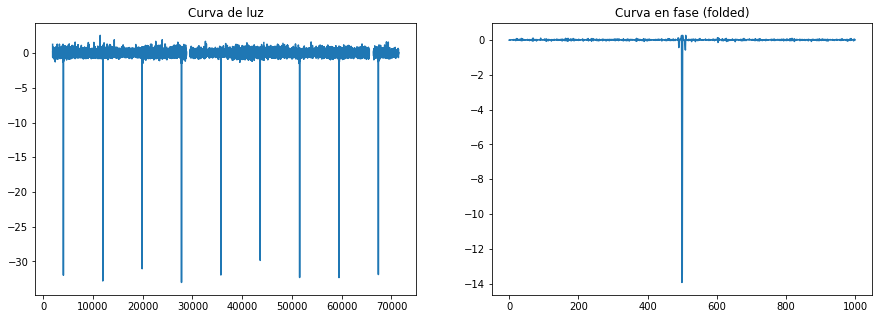

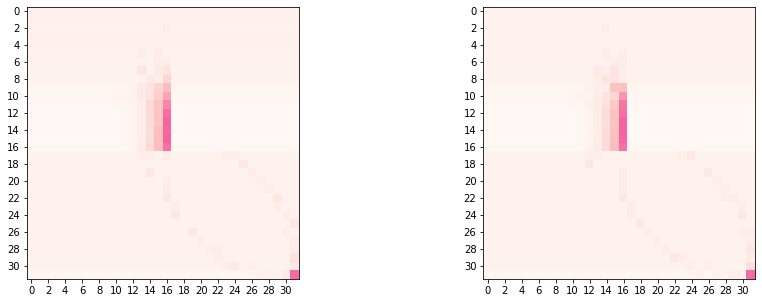

recuperando curva 7


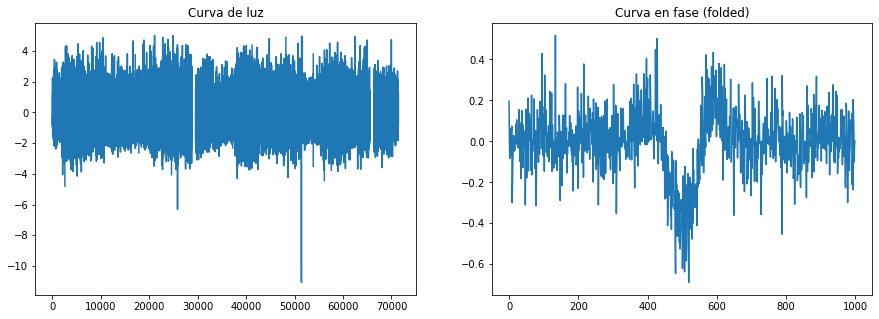

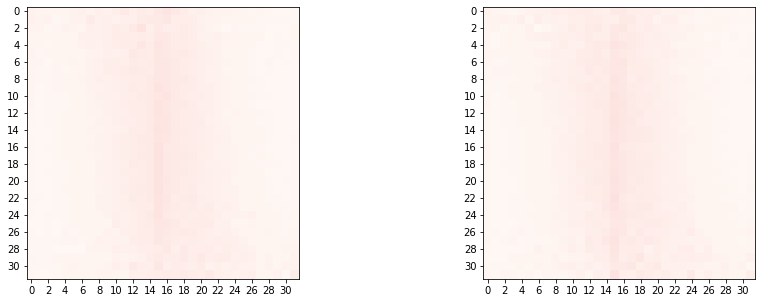

recuperando curva 8


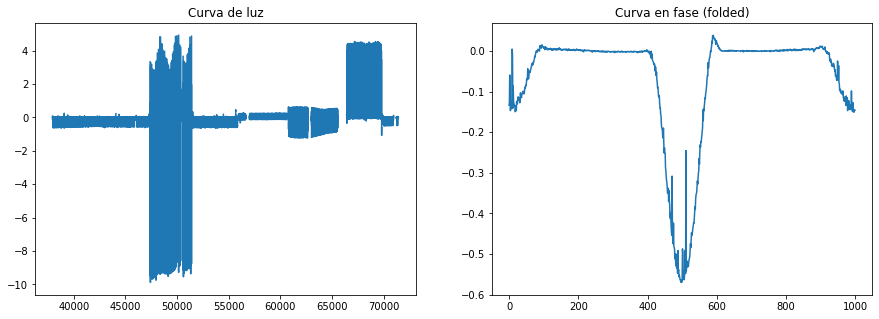

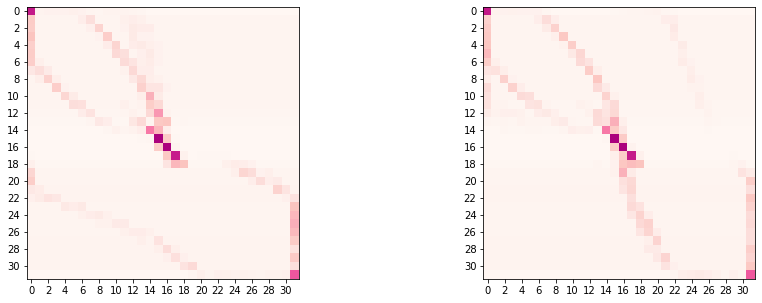

recuperando curva 9


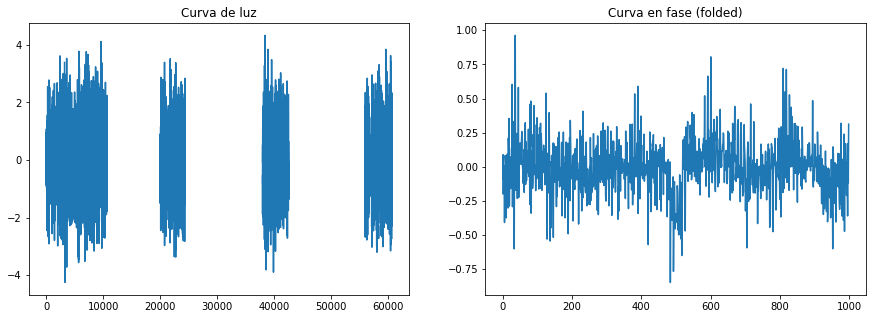

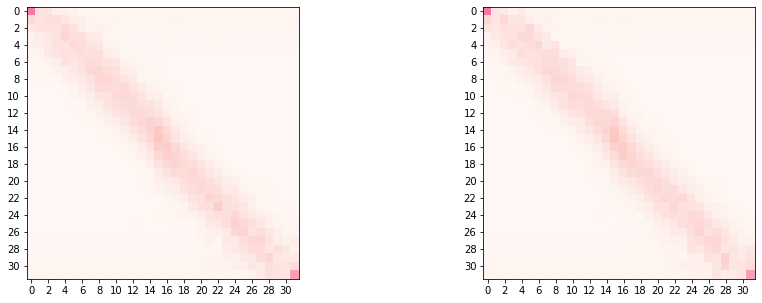

recuperando curva 10


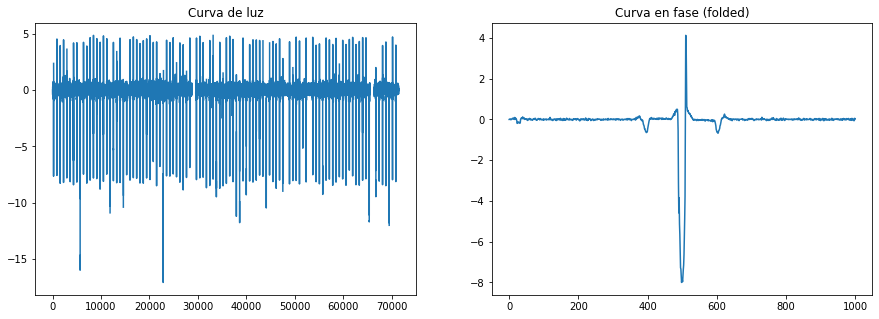

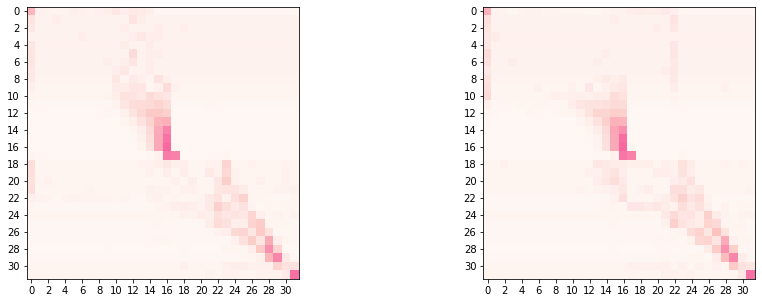

recuperando curva 11


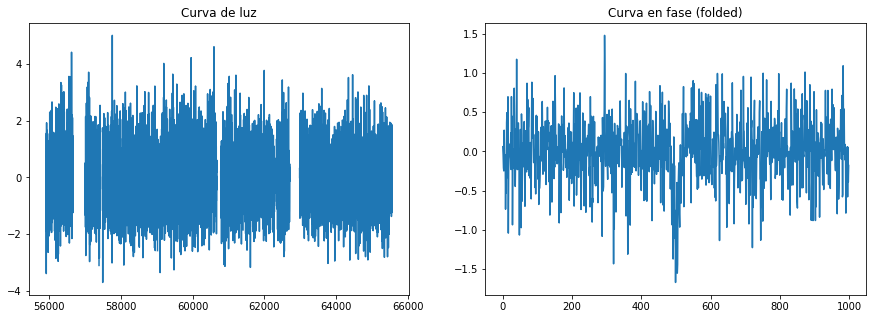

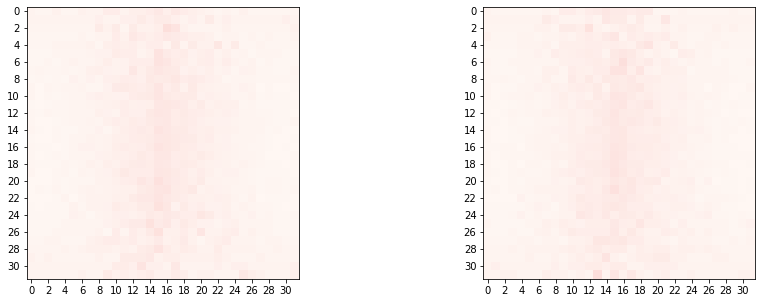

recuperando curva 12


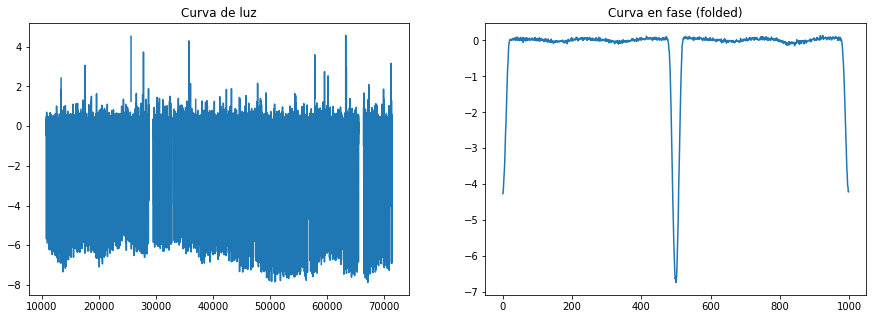

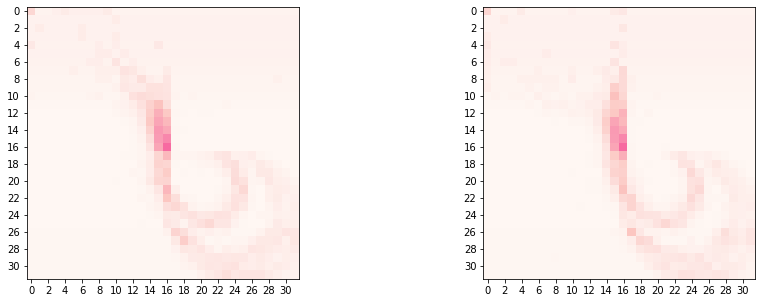

recuperando curva 13


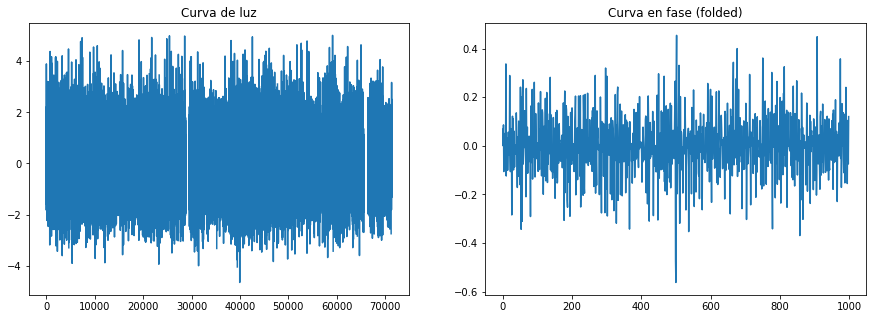

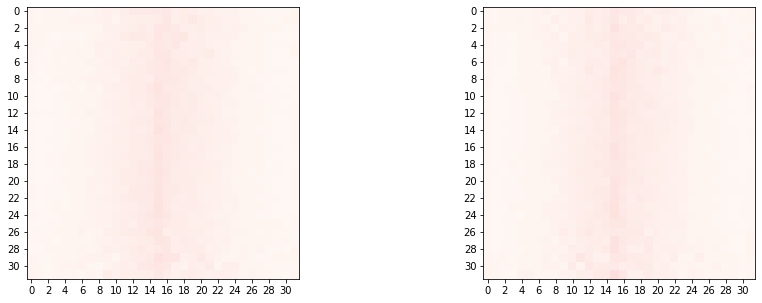

recuperando curva 14


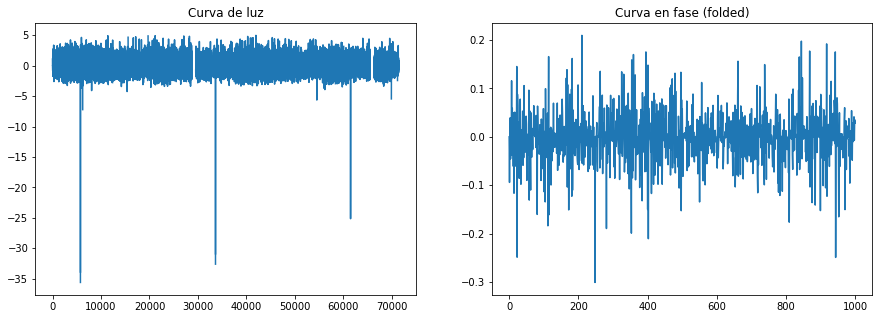

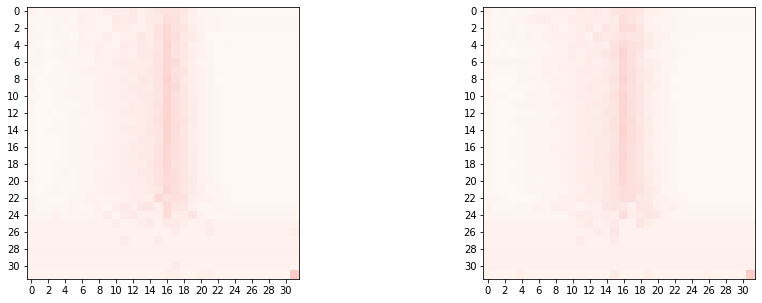

recuperando curva 15


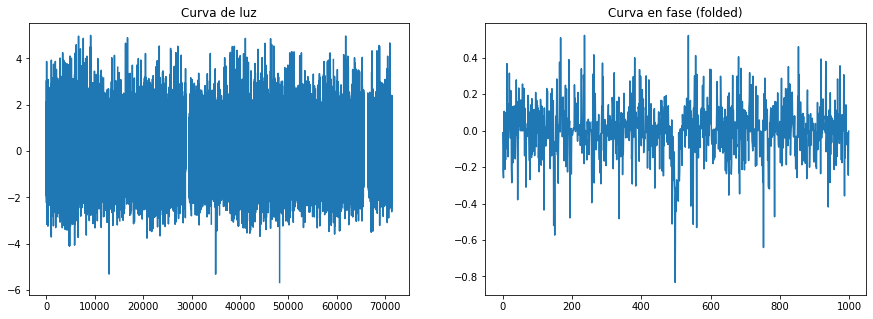

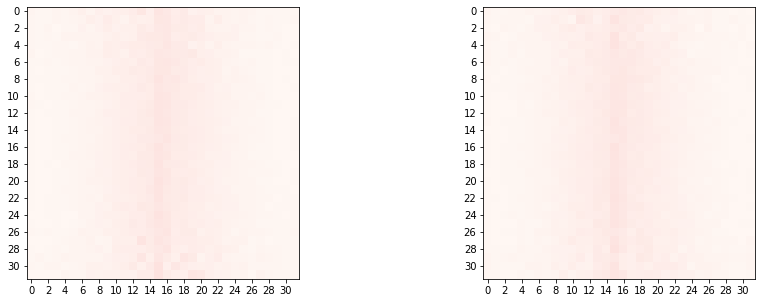

recuperando curva 16


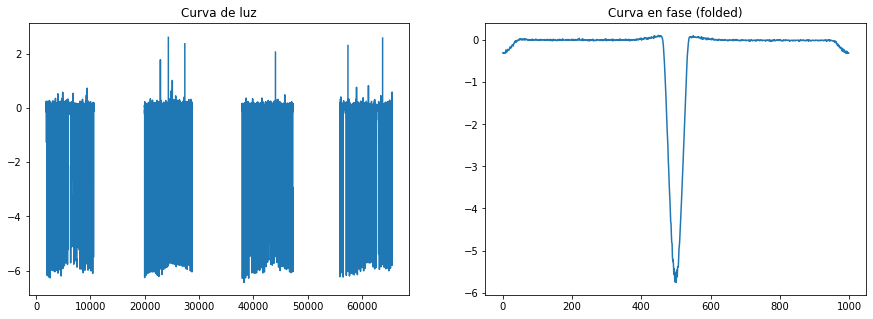

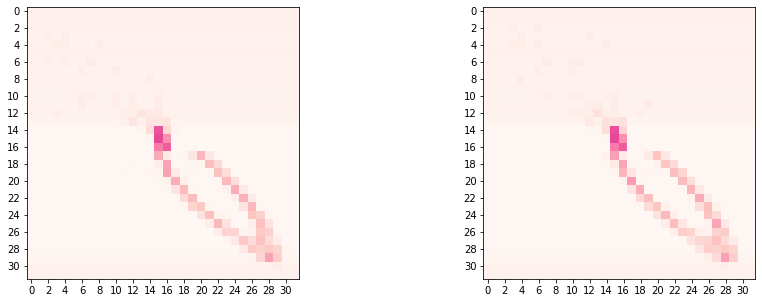

recuperando curva 17


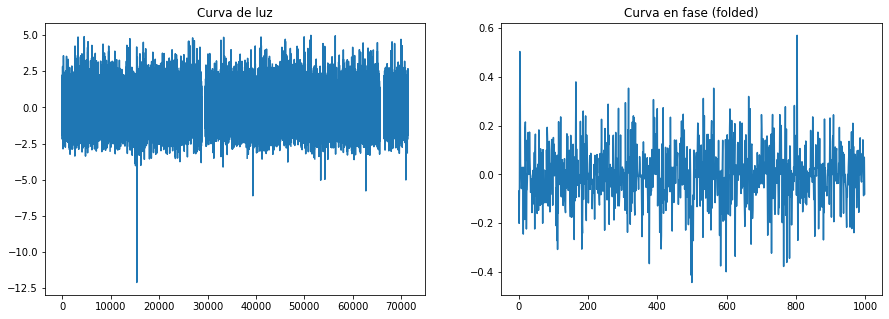

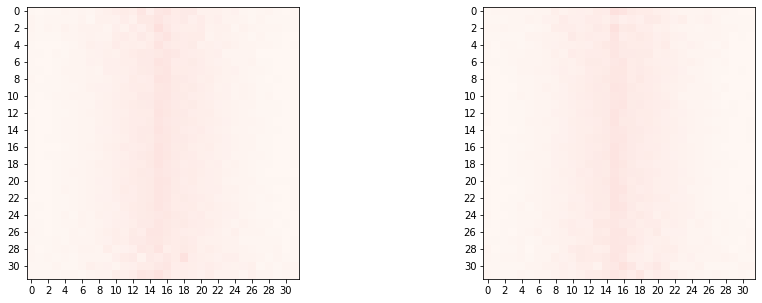

recuperando curva 18


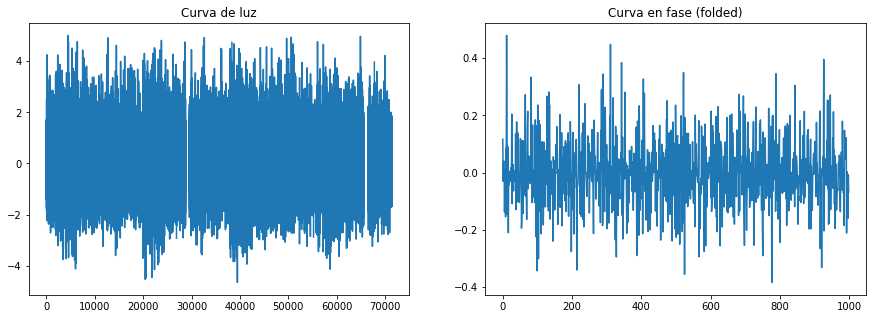

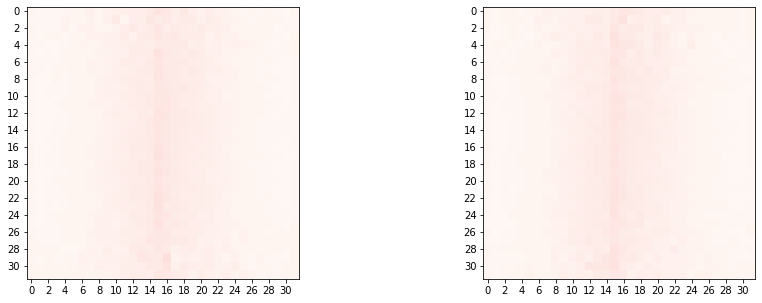

recuperando curva 19


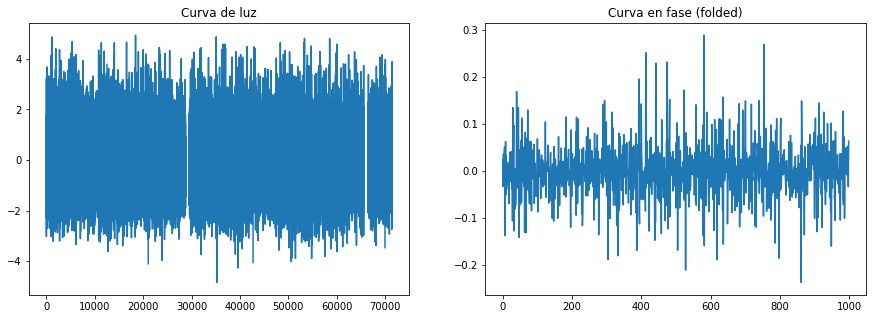

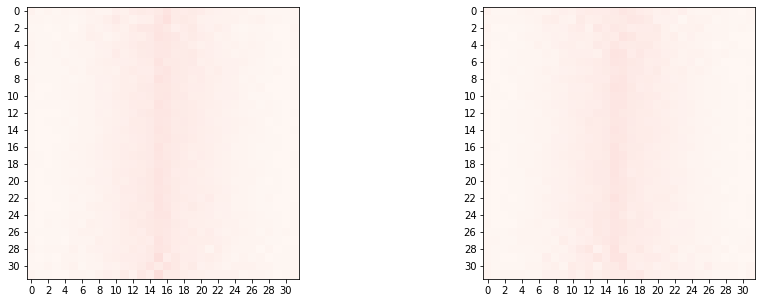

recuperando curva 20


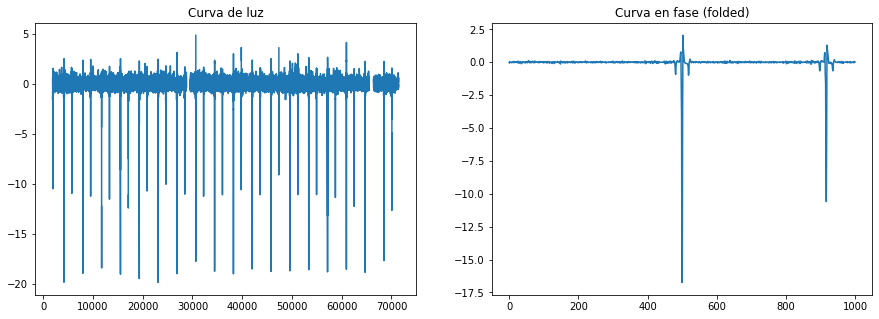

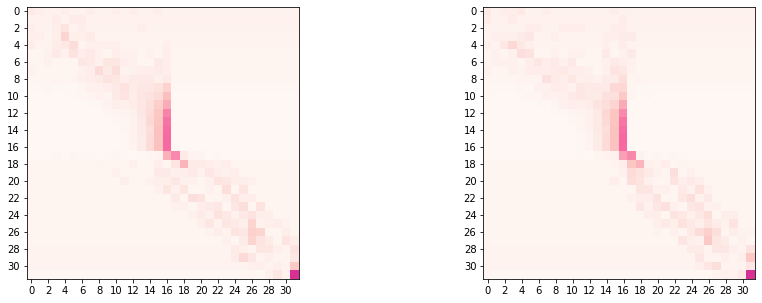

CPU times: user 52.2 s, sys: 10.2 s, total: 1min 2s
Wall time: 1min 1s


In [62]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    
    skew = stats.skew(fluxs, nan_policy='omit')
    states_values = det_state_2ways(3, -3+skew, n_sta_up=16, n_sta_low=16) 
    
    transition_m = manual_HMM(lc_tramos, states_values) 

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, states_values) 
    
    axx[1].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

### Comportamiento Confirmados

In [63]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1


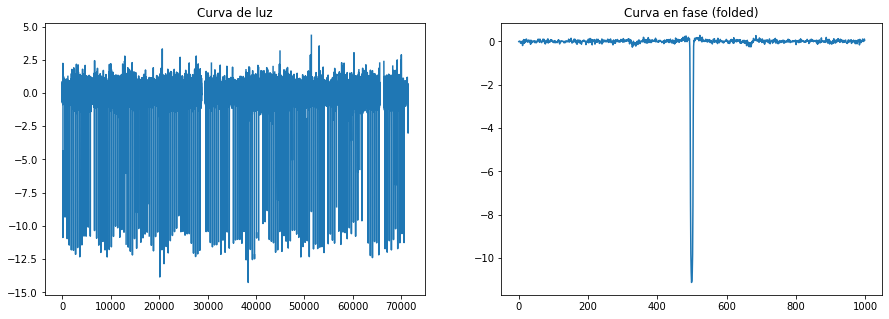

Each bin will have 3.125000 perc probability


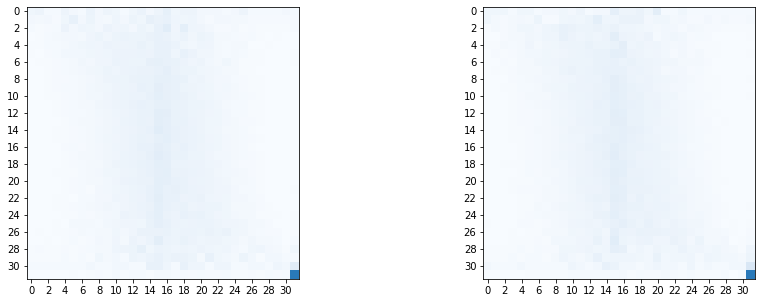

recuperando curva 2


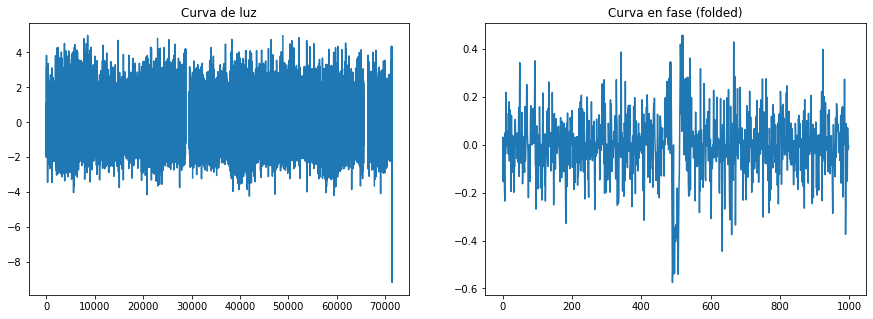

Each bin will have 3.125000 perc probability


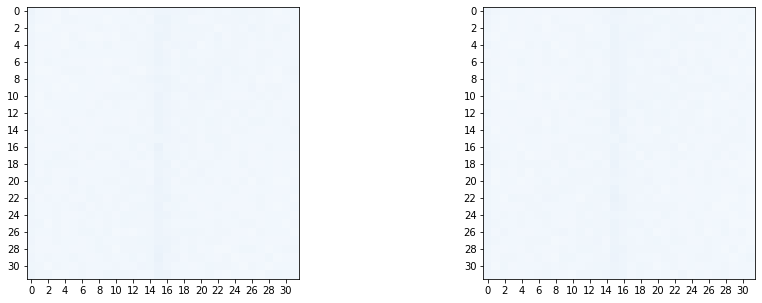

recuperando curva 3


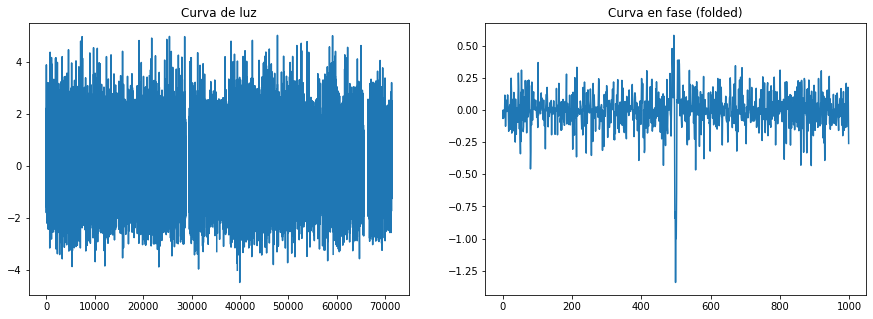

Each bin will have 3.125000 perc probability


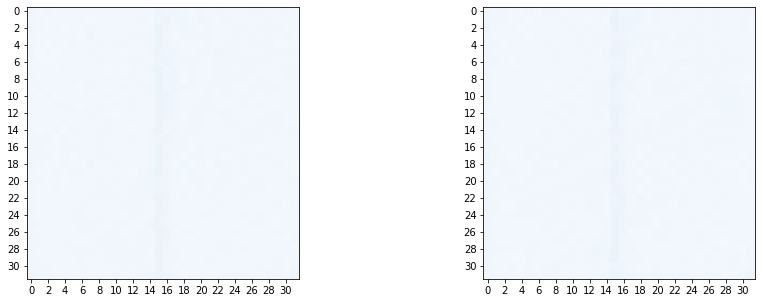

recuperando curva 4


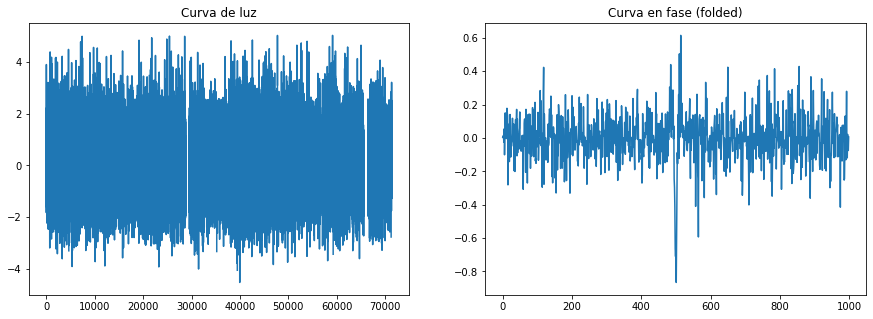

Each bin will have 3.125000 perc probability


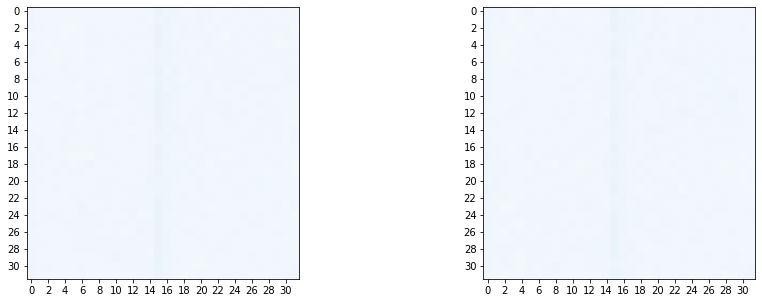

recuperando curva 5


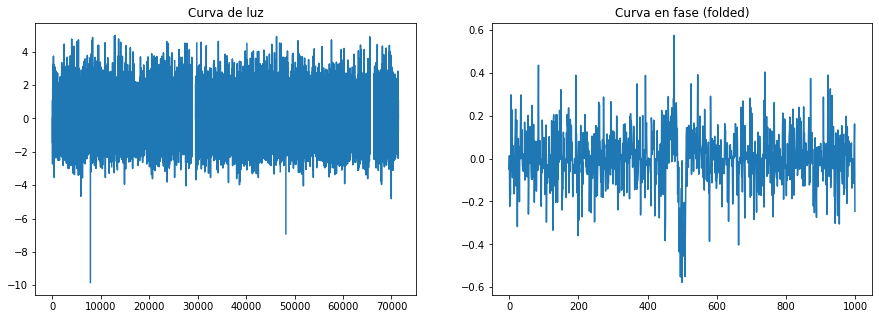

Each bin will have 3.125000 perc probability


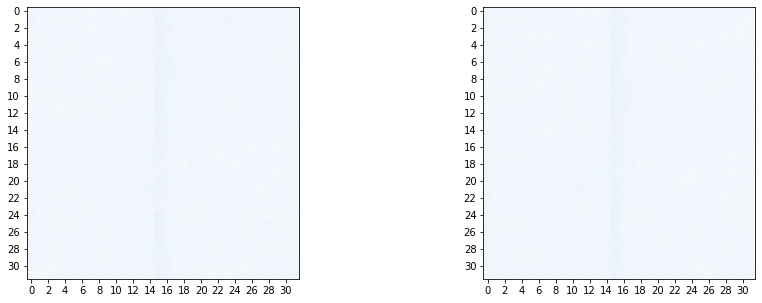

recuperando curva 6


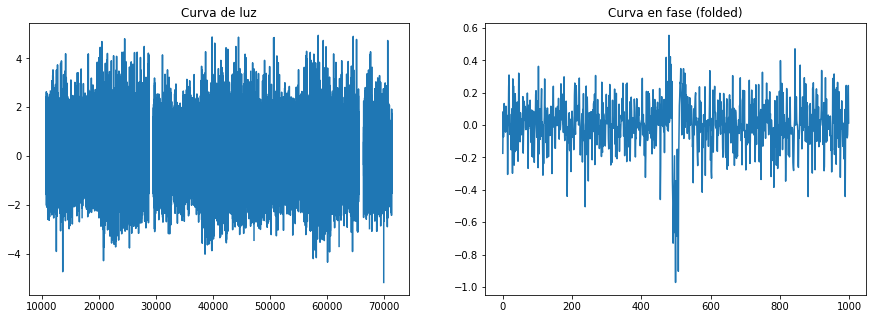

Each bin will have 3.125000 perc probability


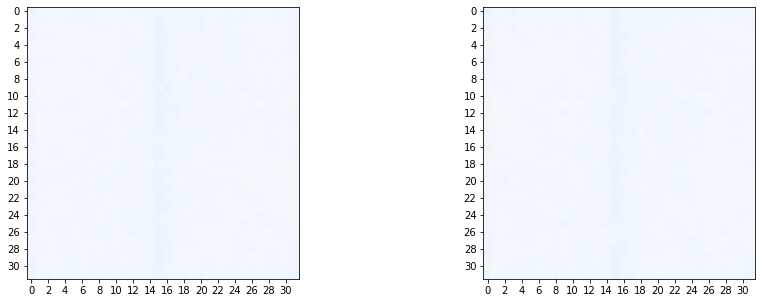

recuperando curva 7


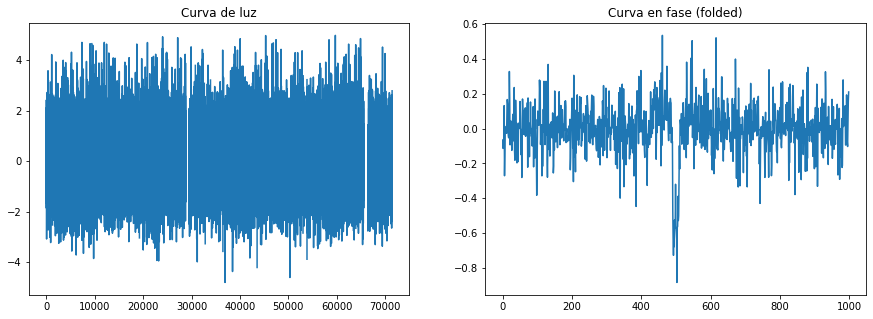

Each bin will have 3.125000 perc probability


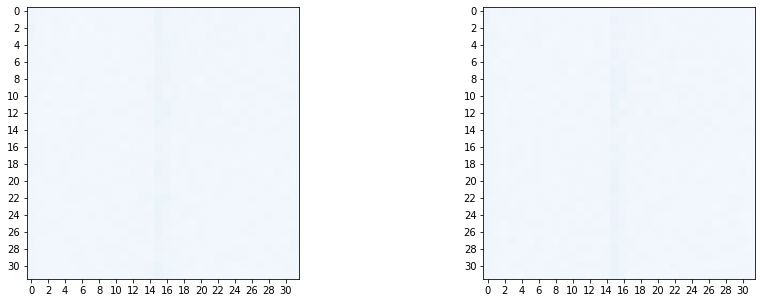

recuperando curva 8


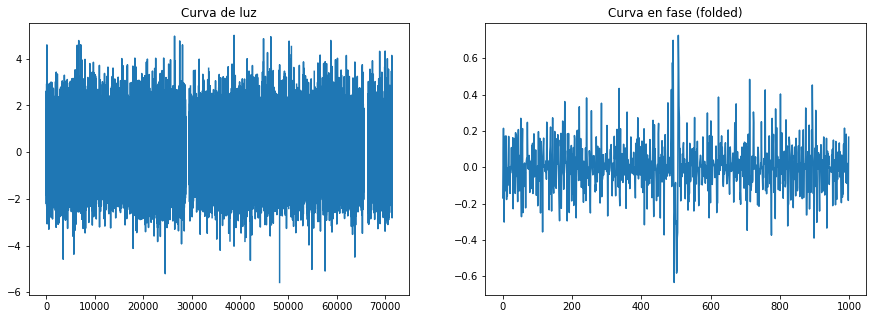

Each bin will have 3.125000 perc probability


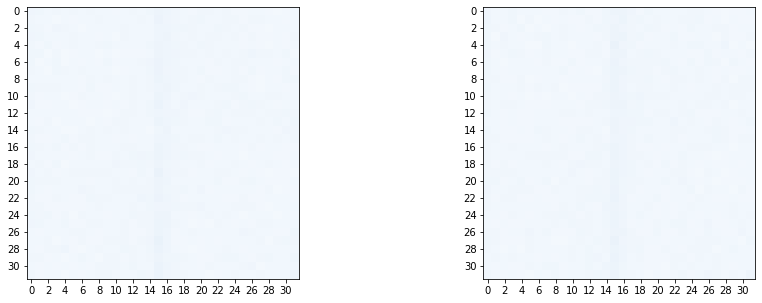

recuperando curva 9


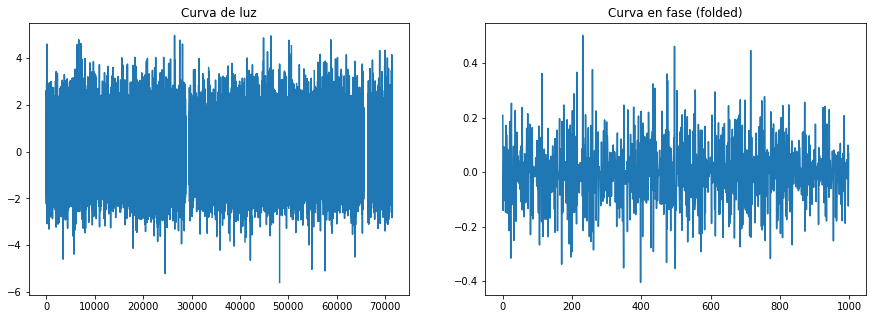

Each bin will have 3.125000 perc probability


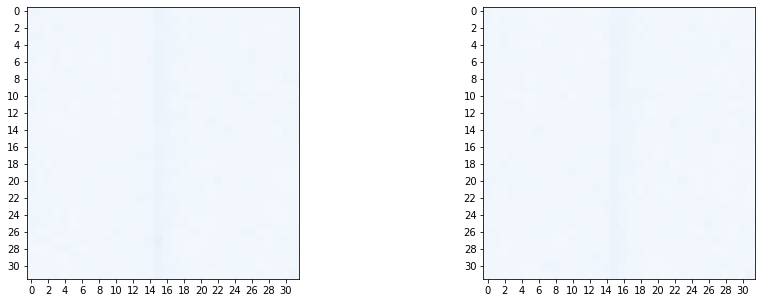

recuperando curva 10


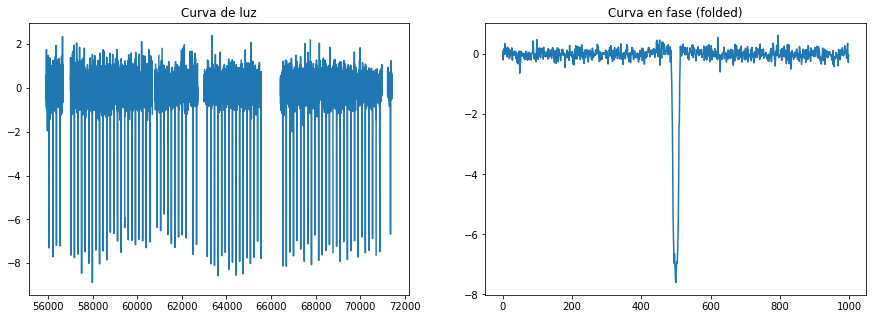

Each bin will have 3.125000 perc probability


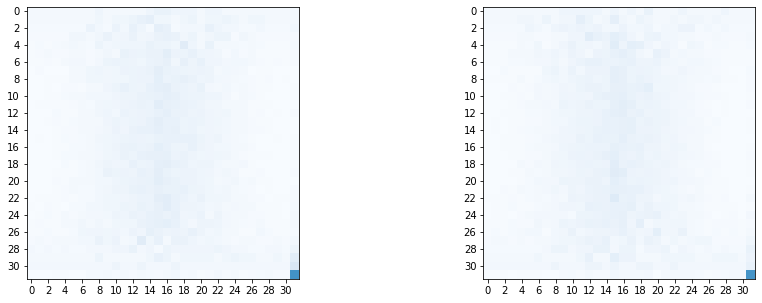

recuperando curva 11


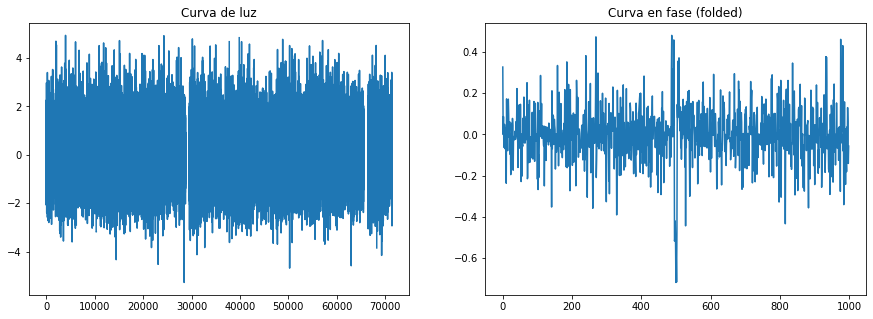

Each bin will have 3.125000 perc probability


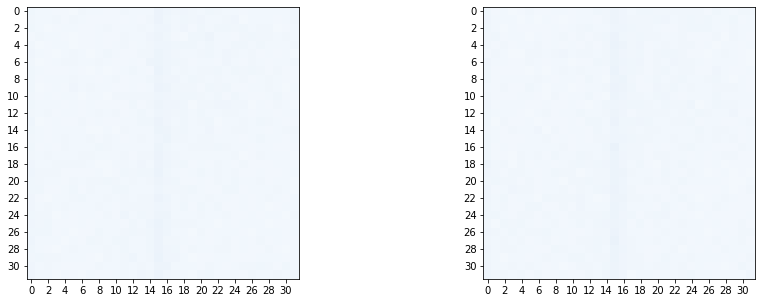

recuperando curva 12


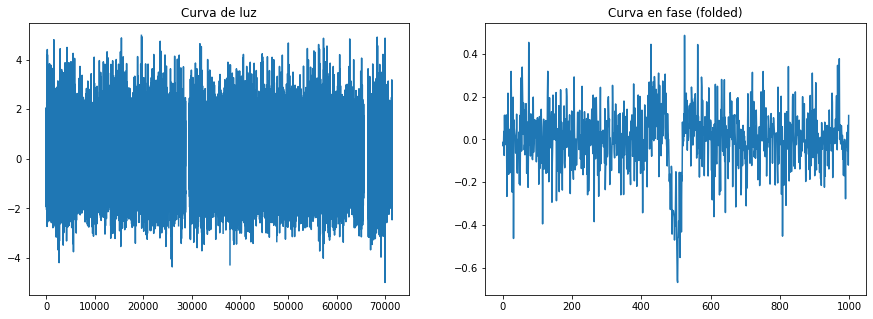

Each bin will have 3.125000 perc probability


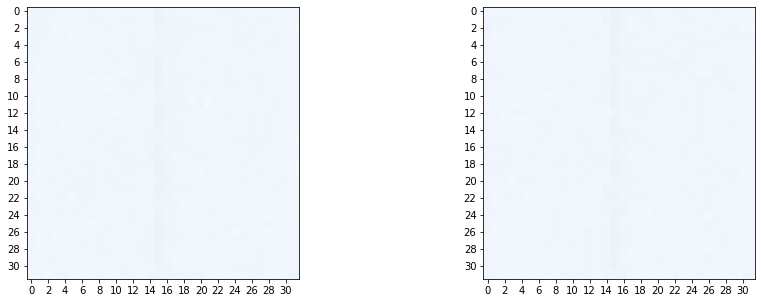

recuperando curva 13


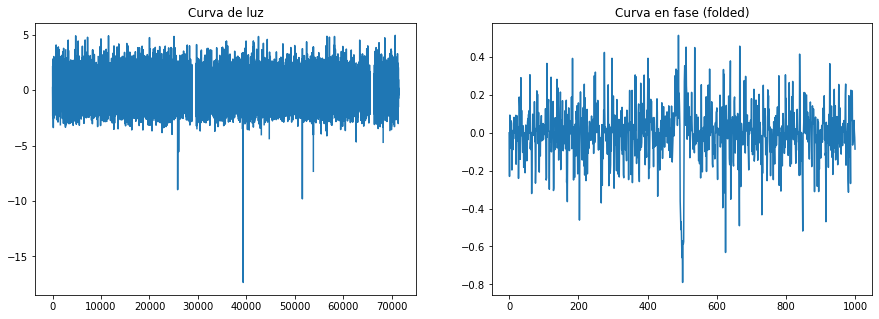

Each bin will have 3.125000 perc probability


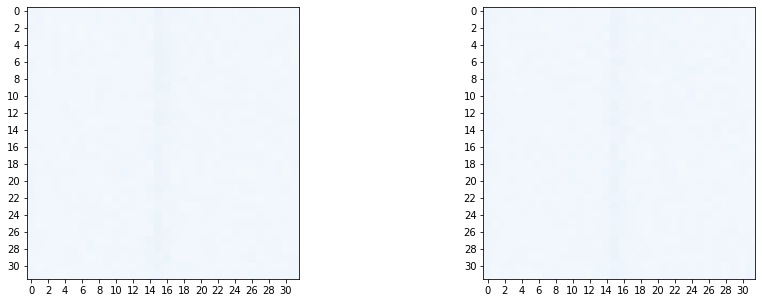

recuperando curva 14


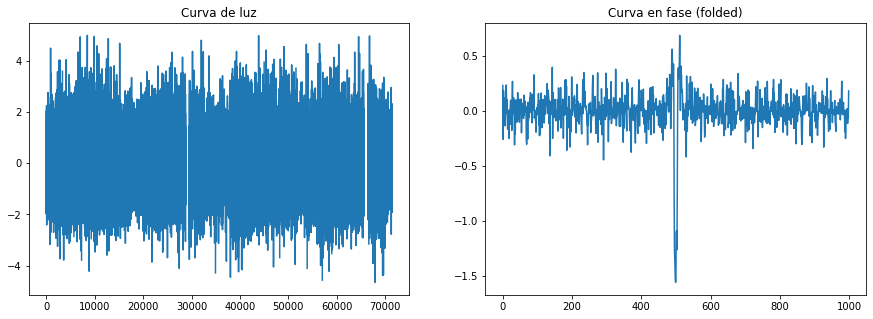

Each bin will have 3.125000 perc probability


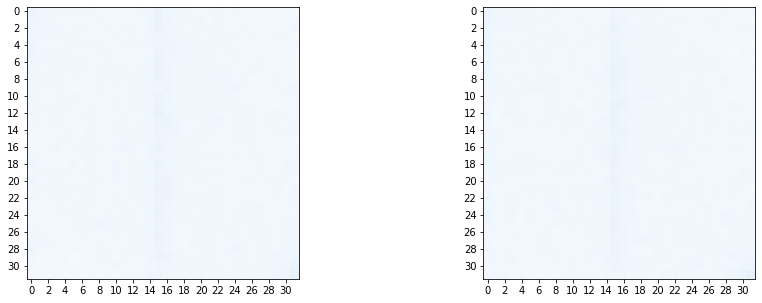

recuperando curva 15


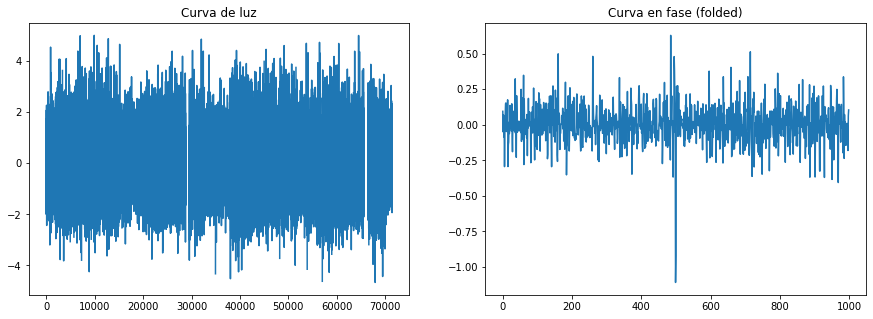

Each bin will have 3.125000 perc probability


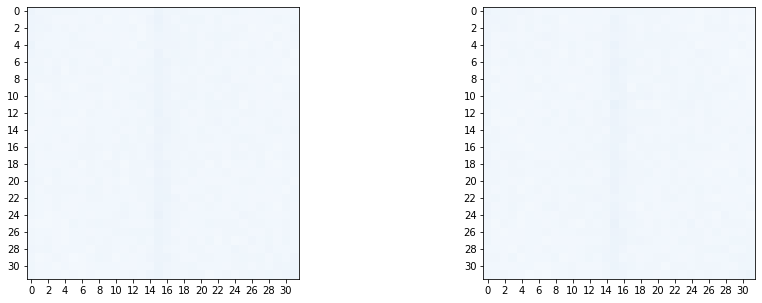

recuperando curva 16


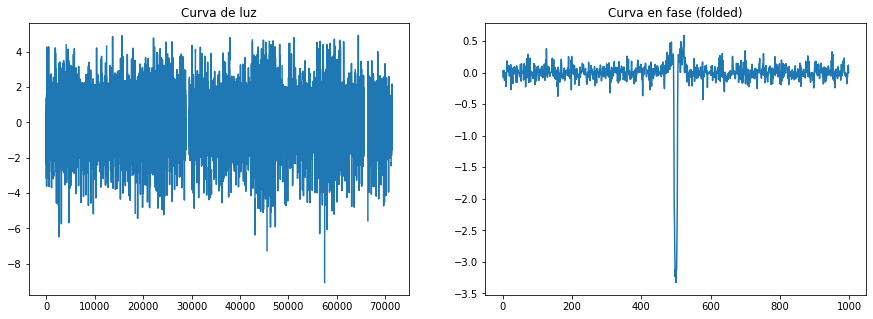

Each bin will have 3.125000 perc probability


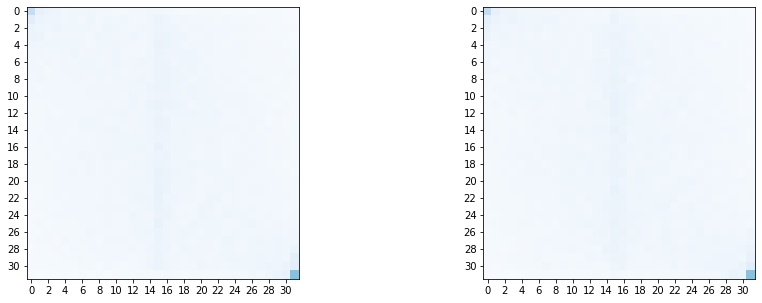

recuperando curva 17


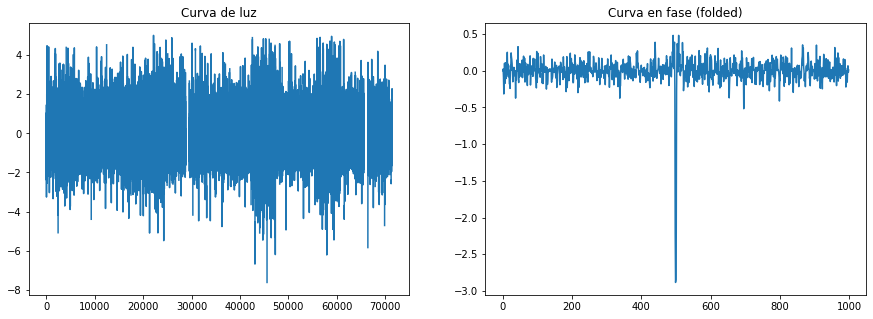

Each bin will have 3.125000 perc probability


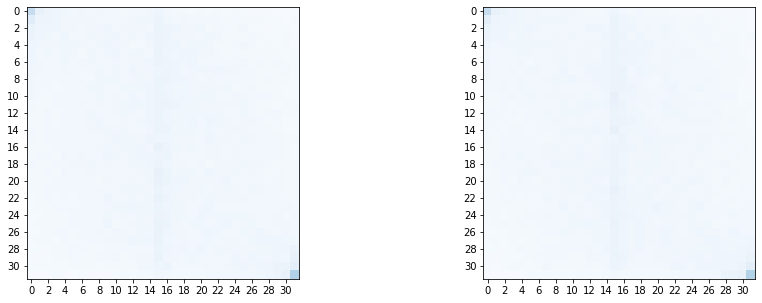

recuperando curva 18


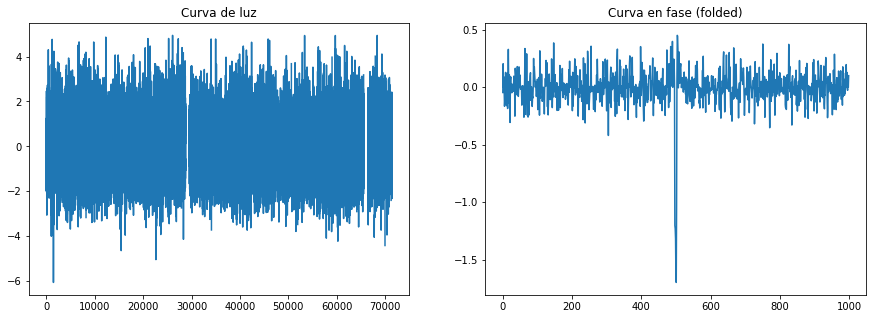

Each bin will have 3.125000 perc probability


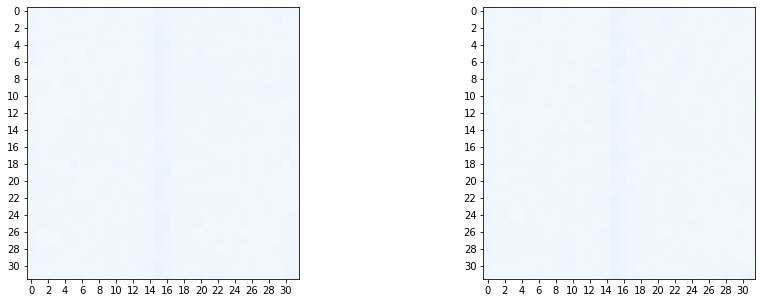

recuperando curva 19


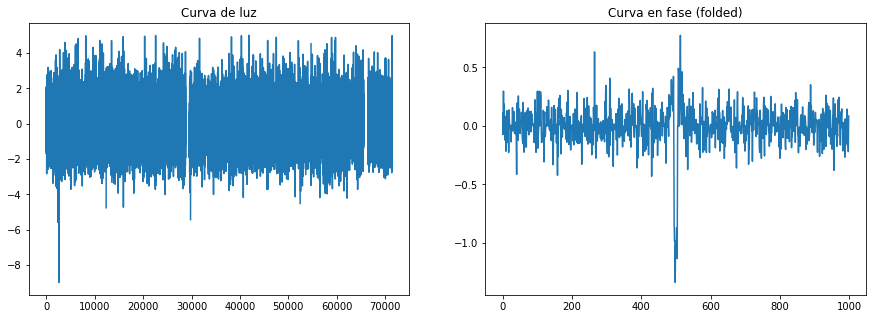

Each bin will have 3.125000 perc probability


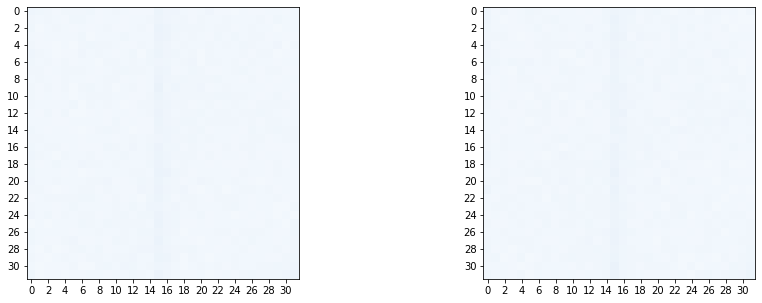

recuperando curva 20


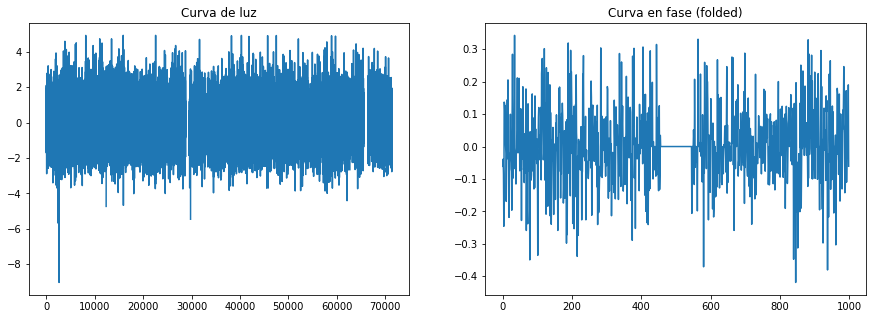

Each bin will have 3.125000 perc probability


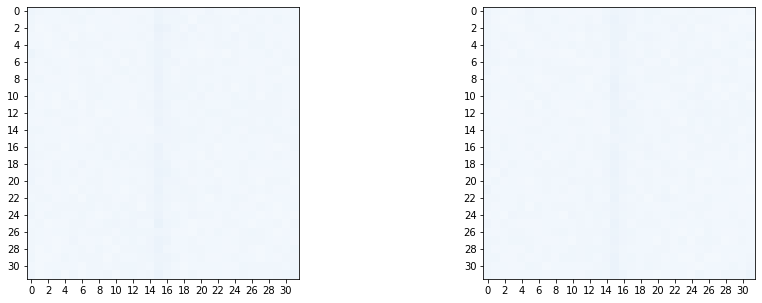

CPU times: user 45.7 s, sys: 6.04 s, total: 51.7 s
Wall time: 50.8 s


In [64]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_con][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_con][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    
    dis_ = stats.norm(loc=0, scale=1)
    states_prob, states_values = det_state_norm(32, dis=dis_)
    
    transition_m = manual_HMM(lc_tramos, states_values) 

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, states_values) 
    
    axx[1].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

recuperando curva 1


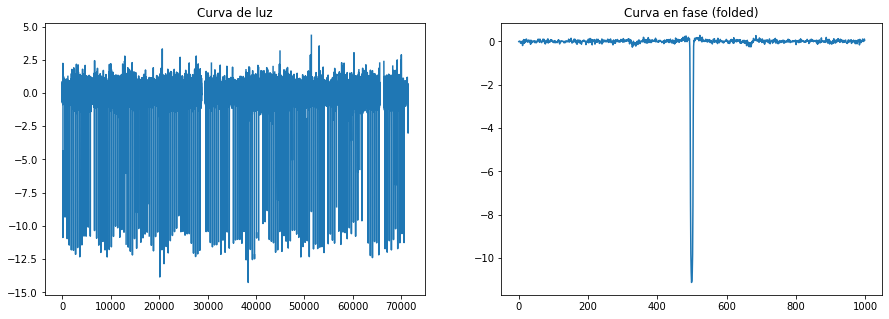

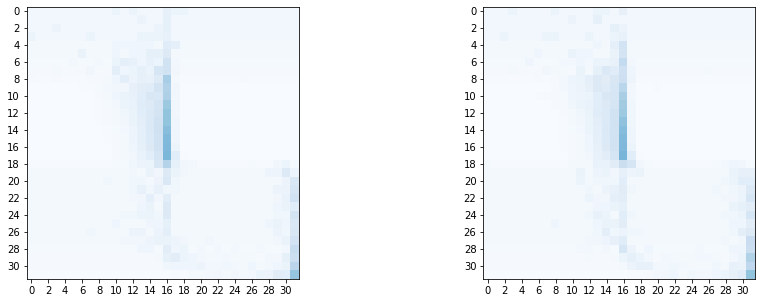

recuperando curva 2


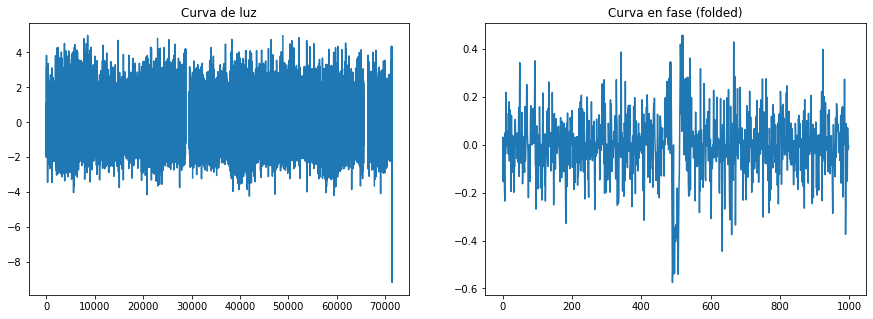

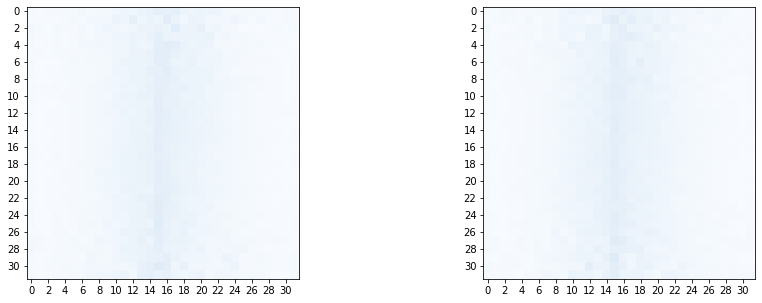

recuperando curva 3


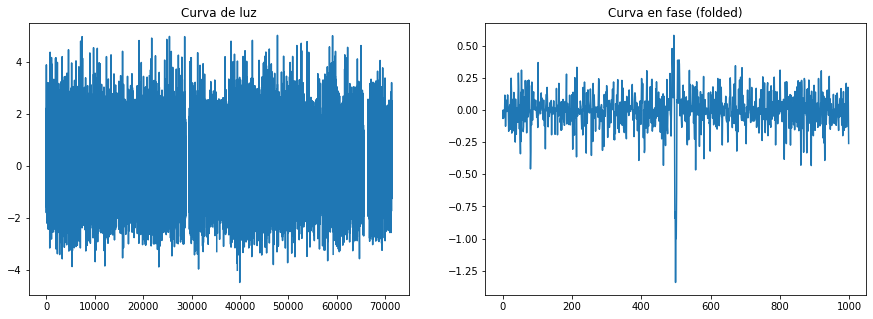

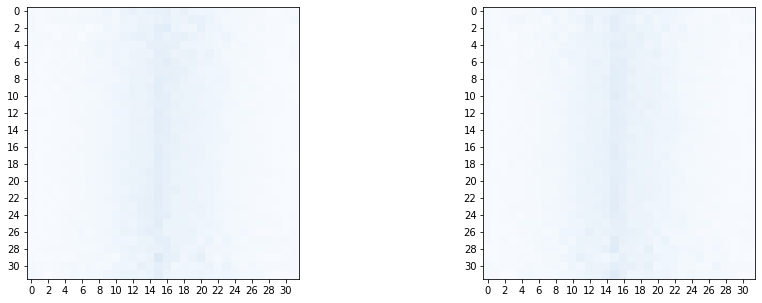

recuperando curva 4


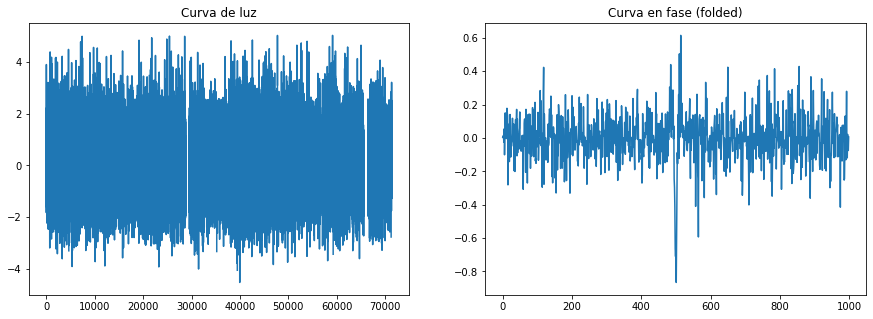

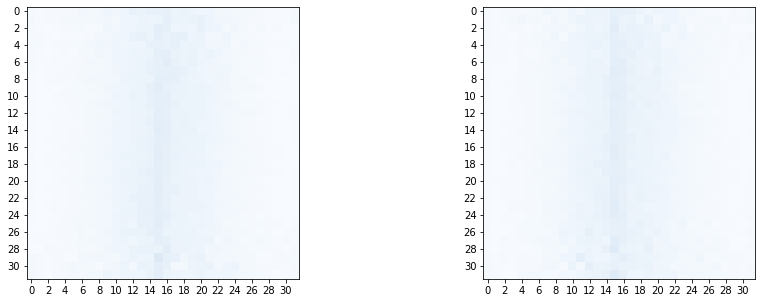

recuperando curva 5


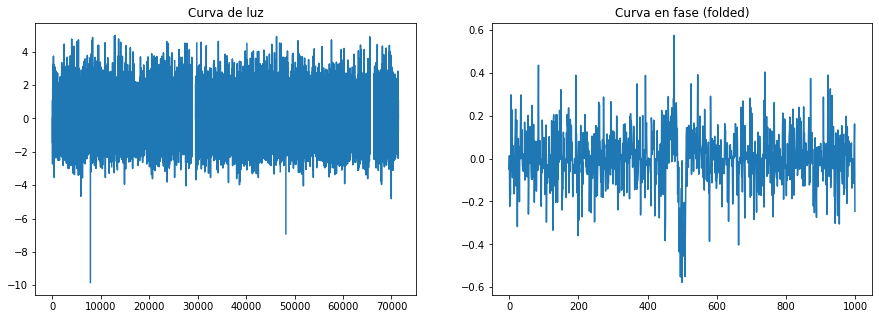

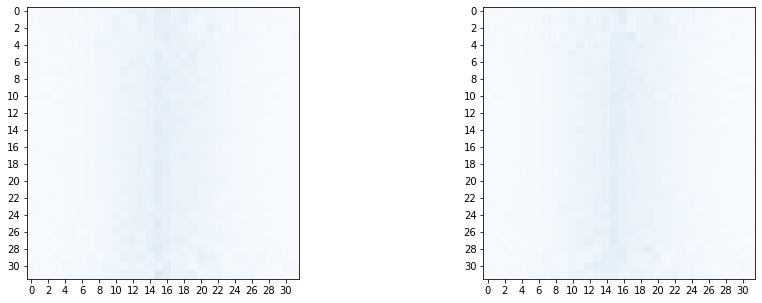

recuperando curva 6


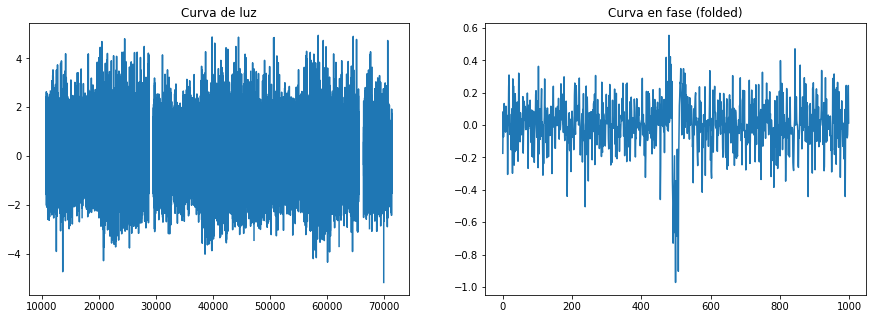

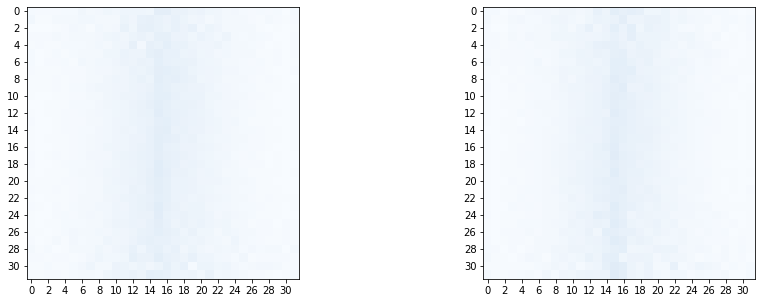

recuperando curva 7


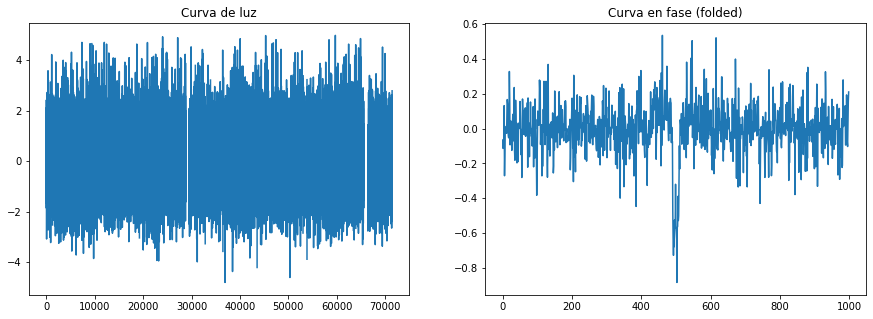

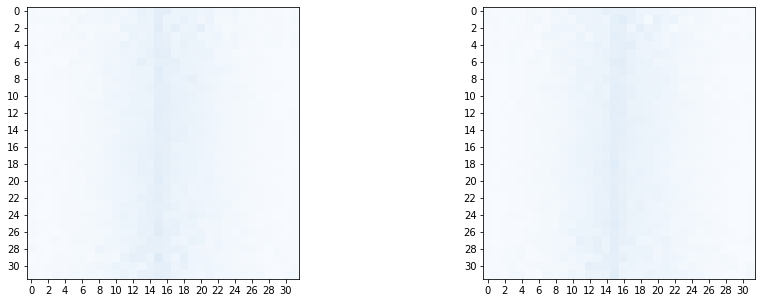

recuperando curva 8


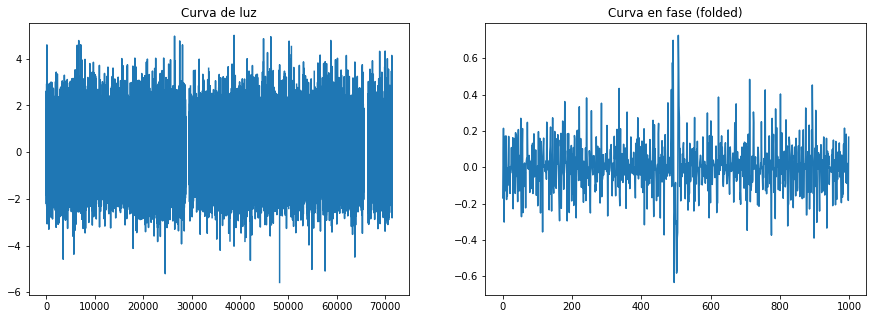

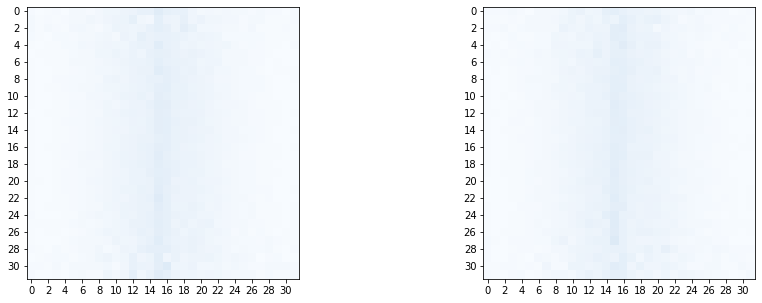

recuperando curva 9


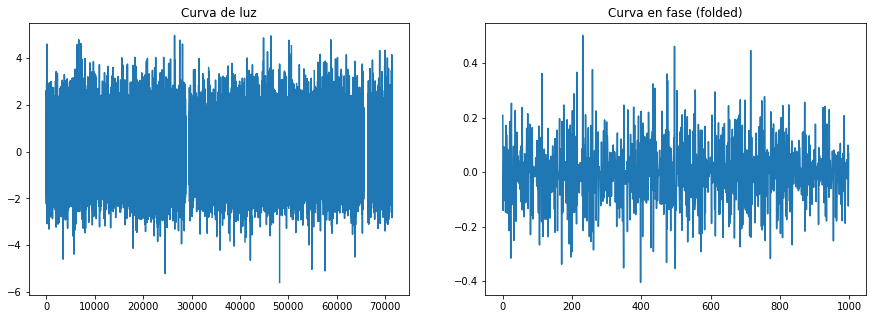

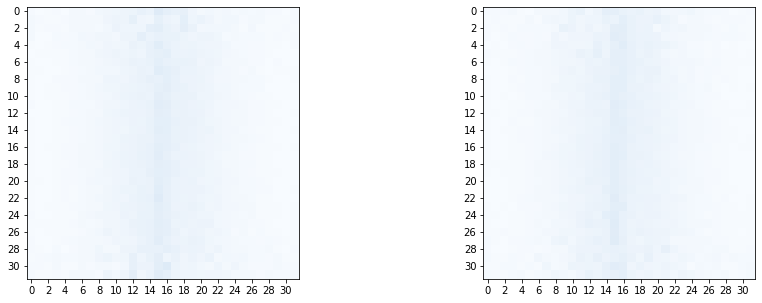

recuperando curva 10


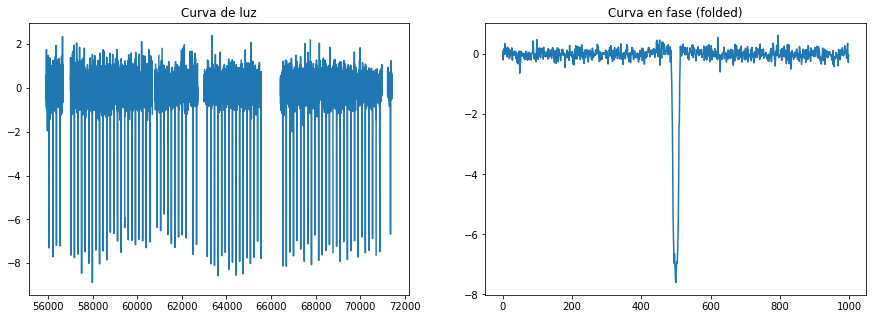

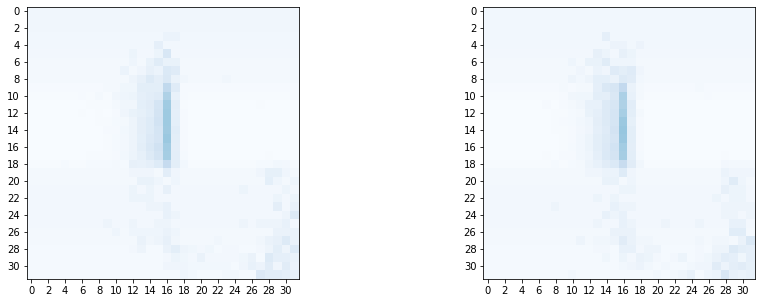

recuperando curva 11


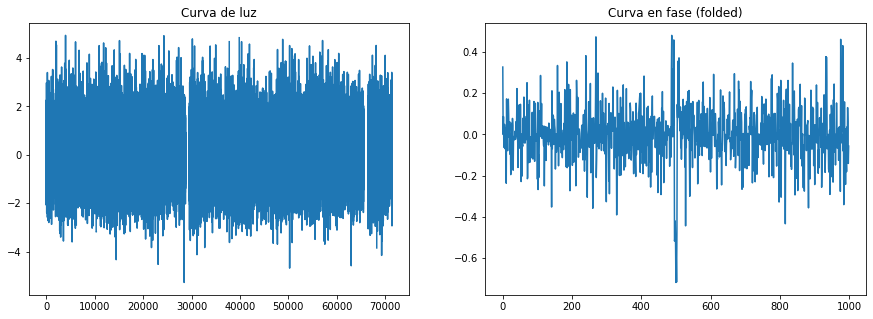

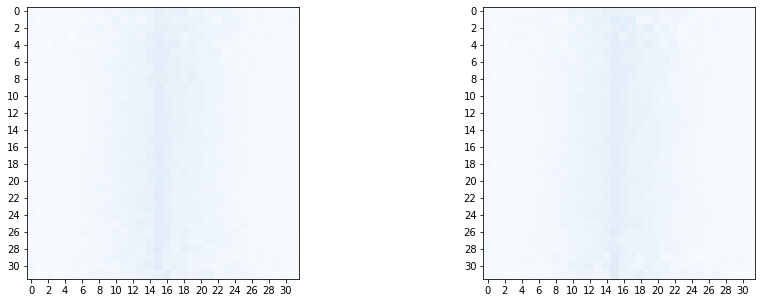

recuperando curva 12


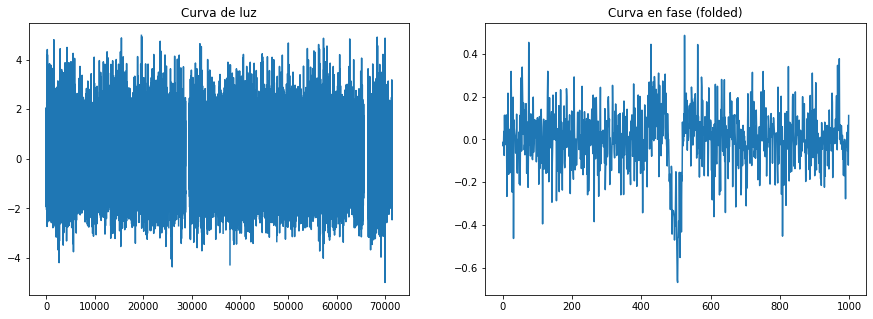

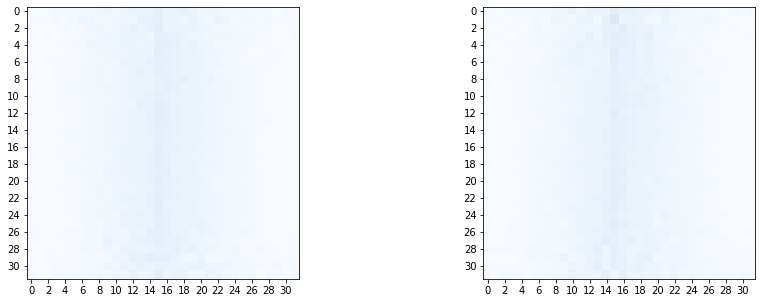

recuperando curva 13


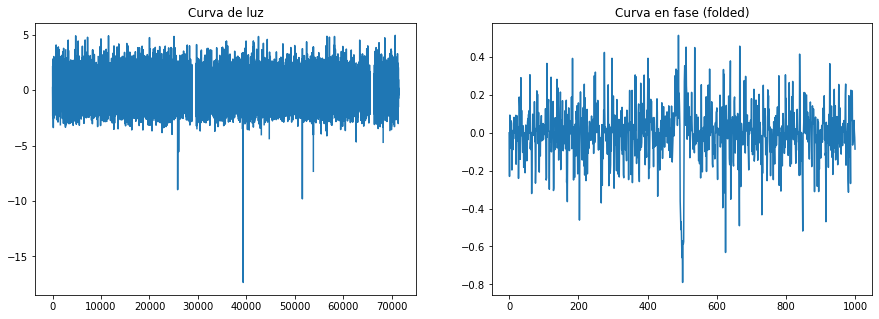

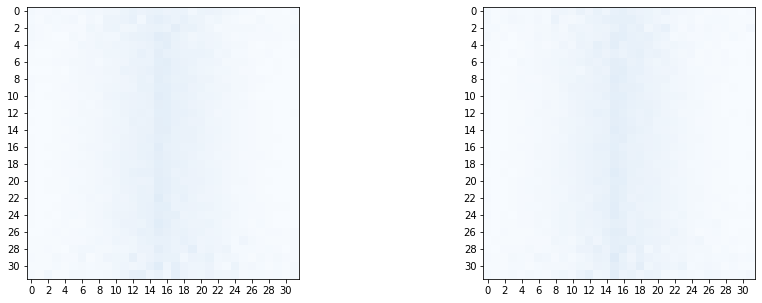

recuperando curva 14


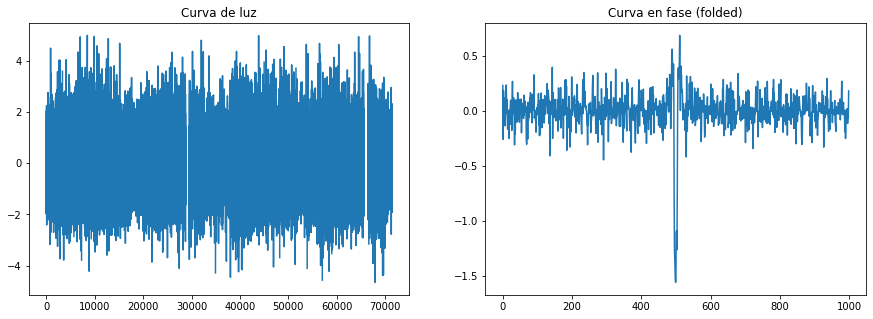

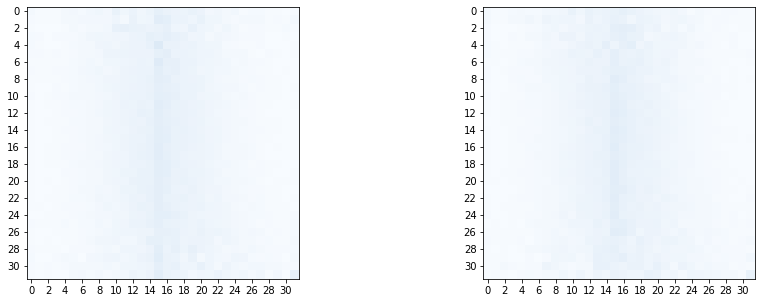

recuperando curva 15


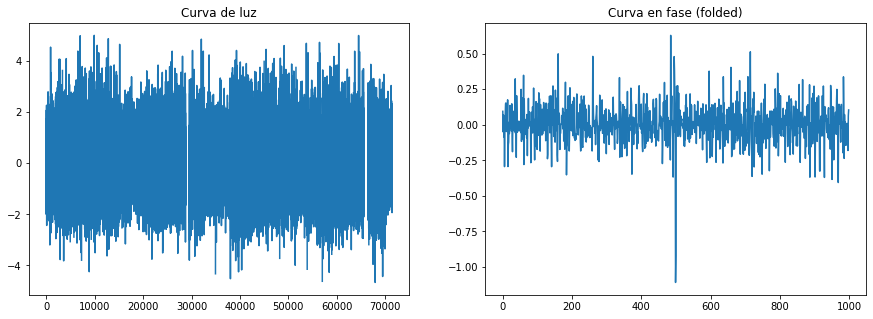

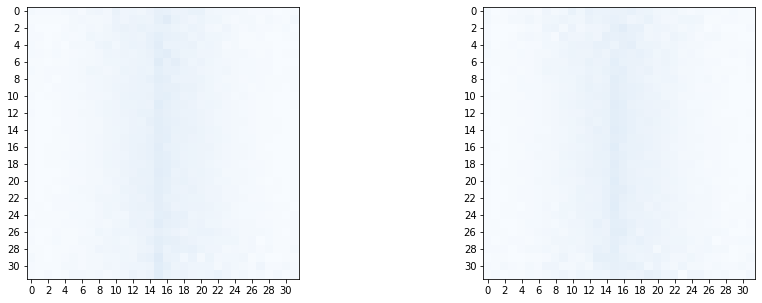

recuperando curva 16


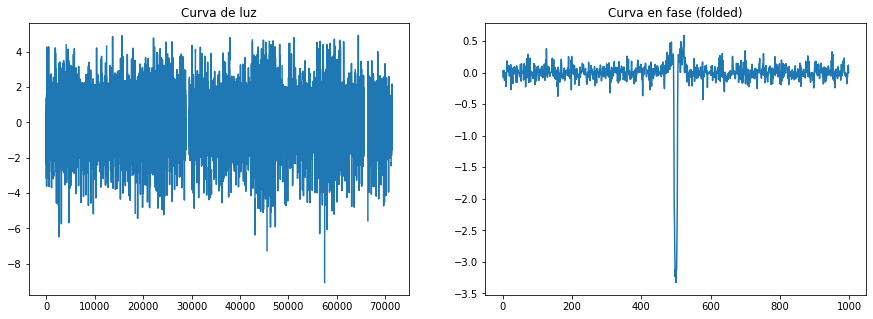

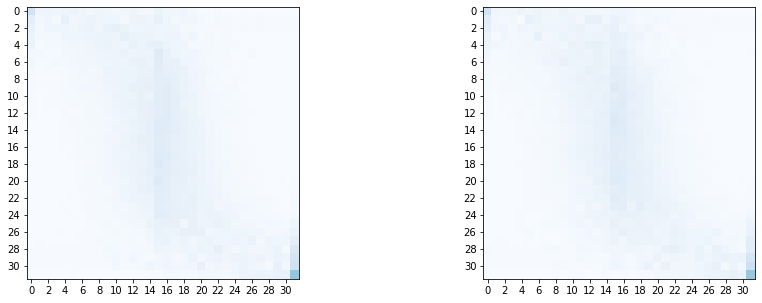

recuperando curva 17


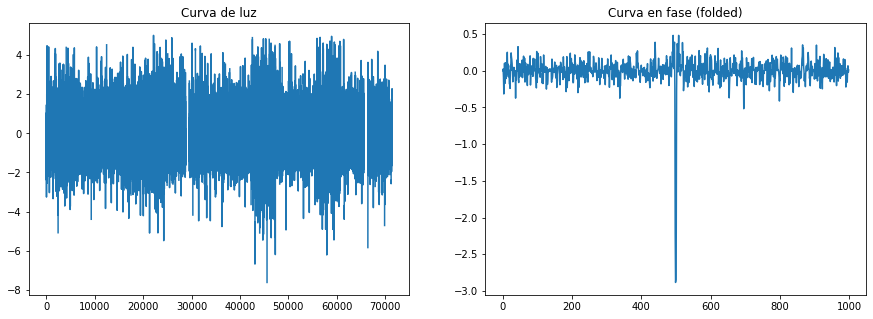

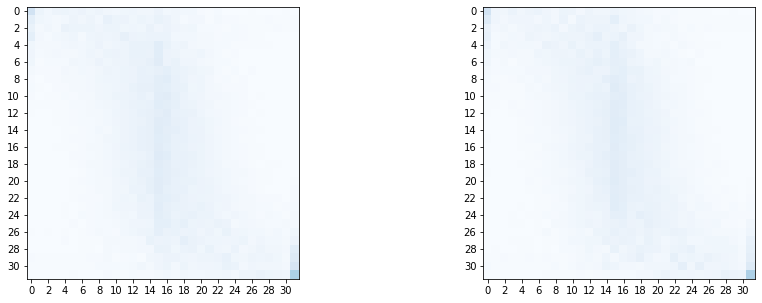

recuperando curva 18


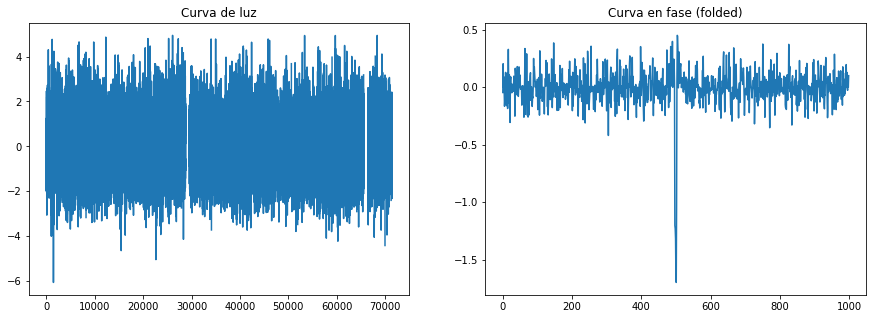

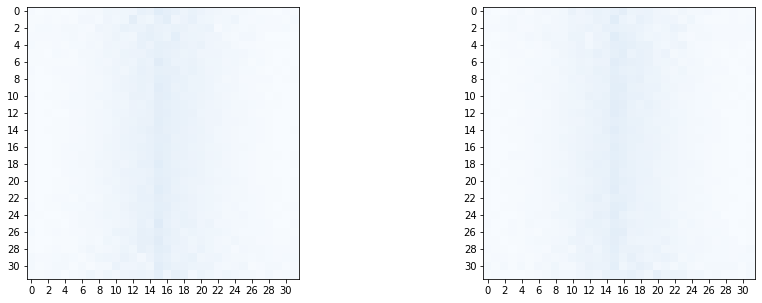

recuperando curva 19


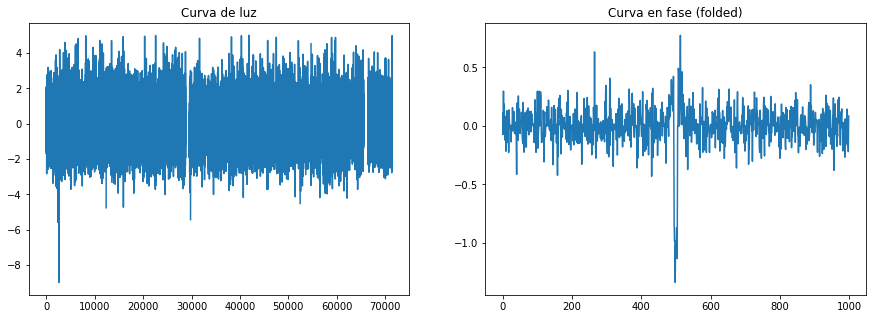

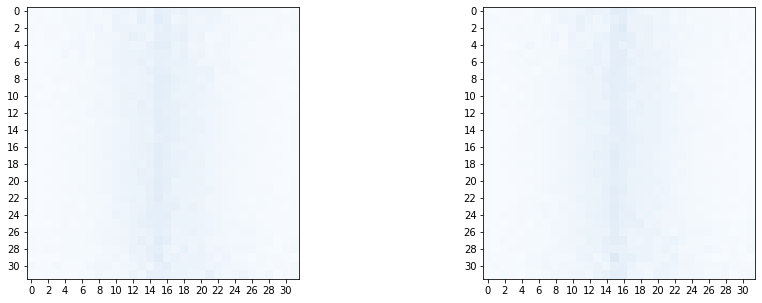

recuperando curva 20


In [ ]:
# %%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_con][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_con][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    
    skew = stats.skew(fluxs, nan_policy='omit')
    states_values = det_state_2ways(3, -3+skew, n_sta_up=16, n_sta_low=16) 
    
    transition_m = manual_HMM(lc_tramos, states_values) 

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, states_values) 
    
    axx[1].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

### Normal (izq - der) NO BORRAR

In [12]:
ups=[8,16,32,64]
downs=[8,16,32,64]

In [ ]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend) 
            lc_tramos =  extract_nans(fluxs) #extract nans\n",
            
            skew = stats.skew(fluxs, nan_policy='omit')
            states_values = det_state_2ways(3, -3+skew, n_sta_up=arriba, n_sta_low=abajo) 
    
            transition_m = manual_HMM(lc_tramos, states_values)     
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_std/no_invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 8 8


<ipython-input-5-fd17e97cf5b9>:50: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'states' of function 'add_transitions'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-fd17e97cf5b9>", line 38:
@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
^

  add_transitions(fluxs, transition_m, states)
<ipython-input-5-fd17e97cf5b9>:50: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'estados' of function 'det_celda'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-fd17e97cf

Creada la configuracion
ARRIBA Y ABAJO 8 16
Creada la configuracion
ARRIBA Y ABAJO 8 32
Creada la configuracion
ARRIBA Y ABAJO 8 64


In [ ]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
            lc_tramos =  extract_nans(fluxs) #extract nans\n",
            skew = stats.skew(fluxs, nan_policy='omit')
            states_values = det_state_2ways(3, -3+skew, n_sta_up=arriba, n_sta_low=abajo) 
    
            transition_m = manual_HMM(lc_tramos, states_values)  
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_std/invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")